# Test notebook for processing stacks downstream of extraction

This code expects input stack folders to have 5 Excel spreadsheets specifically in the CSV format (readble by *csv* library). The specific files are: **graph** (containing mother - daughter cell IDs AKA tree graph edges), **phenotypes** (containing terminal ICM cell IDs and fate calls), **extract_short**, **extract_long** and **extract_histone** (which contain intensities to be analyzed [long typically assumes NANOG and is red, short - GATA6, blue]).

In [1]:
import csv
import os
import numpy as np
import math
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

Main configs:

In [2]:
use_intensity = 'MeanIntensity'
def_method = 'nowarp'
use_method = 'rigid'
prune_termini = False # remove terminal cells that don't trace to the starting frame
trouble = False # print troubleshhoting messages
force_reprocessing = True # force data reprocessing even if pickled data is available
scatter_alpha = 0.5 # transparancy level of scatter plot markers
dot_scale = 500 # scatter plot point size scaling constant
cbins = 50 # force a custom number of huistogram bins
cut = 1 # show only this last part of the video
plot = True # make plots
labels_max = 5 # allow title labels on a grid of no more than X by X
delin_plots = True # make deliniation plots
plot_raw = False # make non-normalized (or raw) angle plots
save_plots = True # save panels
allcell_plot = True # plot all terminal cell traces
prune_lineages = True # prune lineages that are reconstructed incompletely

Core functions:

In [3]:
def exists(frame, idi): # returns a boolean of if a cell with this frame-ID exists
    booly = False
    
    for i in range(len(track)):
        booly = booly or ((track[i][0][0] == frame) and (track[i][0][1] == idi)) or ((track[i][1][0] == frame) and (track[i][1][1] == idi))
    
    return booly


def lineage(frame, idi): # returns a string of frame_IDs for a given cell using the edges from the lineage graph
    found = False
    mother = ['',[]]
    i = 0
    
    while not found and i < len(track):
        if (track[i][1][0] == frame) and (track[i][1][1] == idi):
            lin = lineage(track[i][0][0], track[i][0][1])
            mother[0] = str(track[i][1][0]) + '_' + str(track[i][1][1]) + '<' + lin[0]
            mother[1] = lin[1]
            if track[i][1] in div:
                mother[1].append(track[i][1])
            found = True
        else:
            i = i + 1
      
    return mother


def transform(string): # transforms the lineage() string output to a dataframe
    out = []

    while len(string) > 0:
        sub = string[0:string.index('<')]
        out.append([int(sub[0:sub.find('_')]), int(sub[(1+sub.find('_')):len(sub)])])
        string = string.replace(sub + '<', '')
    
    return np.flip(np.array(out), axis=0)


def find (frame, idi): # returns the short and long camera intensities for a given frame_ID; [-1;-1] if not found
    out = [-1, -1]
    
    for i in range(len(short)):
        if frame == short[i][0] and idi == short[i][1]:
            out = [short[i][2], long[i][2]]
            break
    
    return out


def express(track, interpol = False): # reconstructs the intensity levels of a lineage based of transform() as [frame, ID, short, long, histone]; interpol is the interpolation boolean
    out = []
    
    for t in track:
        temp = find(t[0], t[1])
        temph = -1
        for i in range(len(histone)):
            if t[0] == histone[i][0] and t[1] == histone[i][1]:
                temph = histone[i][2]
                break
        if temp[0] > 0:
            out.append([t[0], t[1], temp[0], temp[1], temph])
    
    return np.array(out)


def terminus(track, frame): # returns a list of cells at target frame
    out = []
    
    for t in track:
        if t[1][0] == frame:
            out.append(t[1])
    
    return out


def prune(stack, allow = 0):  # removes lineages that have fewer than max nodes identified (within allow frames)
    out = []
    max_len = 0
    
    for cell in stack:
        if len(cell[1]) > max_len:
            max_len = len(cell[1])
    
    for cell in stack:
        if max_len - len(cell[1]) <= allow:
            out.append(cell)
    
    return out


def minimal_rectangle(L): # calculates the dimensions of a minimal rectangular grid that can contain L elements
    N = math.ceil(math.sqrt(L))
    M = (L // N) + 1
    
    if N**2 == L:
        M = M - 1
    
    return N, M


def deliniation_plot(label): # makes a large text-only panel deliniating the data shown in the following plots
    x = 0
    y = 0
    plt.figure(figsize = (100, 100))
    plt.scatter(x, y, marker = 'x', alpha = 0)
    plt.annotate(label, xy=(x, y), ha='center', fontsize = 1000)
    plt.axis('off')
    plt.show()

    
def colsel(p): # select colour based on label
    if p == 'EPI1':
        col = 'crimson'
    elif p == 'PE':
        col = 'mediumblue'
    elif p == 'EPI2':
        col = 'goldenrod'
    elif p == 'DN1':
        col = 'crimson'
    elif p == 'DN2':
        col = 'goldenrod'
    else:
        col = 'Black'
        print('Color selection failed, defaulting to: ' + col)
    
    return col

Plot-making function (customize plots per stack here or copy and make your own):

In [4]:
def make_plots(lineages, plotn): # make a set of plots for a set of tracked cells
    
    # format key variables
    stack = lineages
    cells = stack[1]
    N, M = minimal_rectangle(cells)
    titles = (N <= labels_max)
    plotnum = plotn
    
    # set terminal point beeswarm color
    cl = 'Black'
    if '-' in stack[0]:
        cl = colsel(stack[0][stack[0].find('-') + 1 : len(stack[0])])
    
    deliniation_plot(stack[0])
    
    # plot globally minmax-normalized intensities 
    for i in range(cells):
        plt.subplot(N, M, i + 1)
        plt.axis('off')
        if titles: # plot titles (frame-ID) are shown if there are N columns or less than the limit labels_max (essentially, if there aren't too many plots being rendered)
            plt.title(stack[2][i][0], fontsize = 10)
        plt.ylim(0, 1)
        plt.xlim(start_frame, end_frame)
        plt.plot(stack[2][i][1][:,0], (stack[2][i][1][:,4] - black_min)/(black_max - black_min), c='Black')
        plt.plot(stack[2][i][1][:,0], (stack[2][i][1][:,2] - blue_min)/(blue_max - blue_min), c='Blue')
        plt.plot(stack[2][i][1][:,0], (stack[2][i][1][:,3] - red_min)/(red_max - red_min), c='Red')
    
    if save_plots:
        name = str(plotnum) + '.png'
        plt.savefig(os.path.join(plot_directory, name))
        plotnum += 1
    
    plt.show()
    
    # plot the short-long angles of globally minmax-normallized intensity ratios
    for i in range(cells):
        plt.subplot(N, M, i + 1)
        plt.ylim(0, math.pi/2)
        plt.axis('off')
        if titles:
            plt.title(stack[2][i][0], fontsize = 10)
        temp = []
        for j in range(len((stack[2][i][1]))):
            temp.append(math.pi/2 - math.atan(((stack[2][i][1][j, 2] + 0.000001 - blue_min)/(blue_max - blue_min))/((stack[2][i][1][j, 3] + 0.000001 - red_min)/(red_max - red_min))))
        plt.plot(stack[2][i][1][:,0], temp, c='Orange')
    
    if save_plots:
        name = str(plotnum) + '.png'
        plt.savefig(os.path.join(plot_directory, name))
        plotnum += 1
    
    plt.show()
    
    # plot the short-long angle of globally minmax-normallized intensity ratios with threshold lines (cut marker-dash version)
    for i in range(cells):
        plt.subplot(N, M, i + 1)
        plt.ylim(0, math.pi/2)
        plt.axis('off')
        temp = []
        for j in range(round(len((stack[2][i][1])) * (1 - cut)), len((stack[2][i][1]))):
            temp.append(math.pi/2 - math.atan(((stack[2][i][1][j, 2] + 0.000001 - blue_min)/(blue_max - blue_min))/((stack[2][i][1][j, 3] + 0.000001 - red_min)/(red_max - red_min))))
        plt.plot(stack[2][i][1][round(len((stack[2][i][1])) * (1 - cut)):,0], temp, marker='o', markersize=1, linestyle='-', linewidth = 0.2, c='Orange')
    
    if save_plots:
        name = str(plotnum) + '.png'
        plt.savefig(os.path.join(plot_directory, name))
        plotnum += 1
    
    plt.show()
    
    # plot the short-long angle of globally minmax-normallized intensity ratio distribution
    temp = []
    for i in range(cells):
        temp.append(math.pi/2 - math.atan(((stack[2][i][1][len(stack[2][i][1]) - 1, 2] - blue_min)/(blue_max - blue_min)) / ((stack[2][i][1][len(stack[2][i][1])-1, 3] + 0.000001 - red_min)/(red_max - red_min))))
    sns.swarmplot(y=temp, color = cl)
    plt.ylim(0, math.pi/2)
    plt.title(stack[0] + ' terminal frame angle distribution')
    plt.ylabel('Short/Long Intensity Angle (rad)')
    plt.xticks([])
    
    if save_plots:
        name = str(plotnum) + '.png'
        plt.savefig(os.path.join(plot_directory, name))
        plotnum += 1
    
    plt.show()
    
    return plotnum

Reconstruct lineages (must be run in a folder with stack folders):

In [5]:
main_directory = os.getcwd() # must be run in a folder with stack folders

given_stacks = ['stack6'] # name specific stack folders to process; if blank the code will grab all non-silenced stacks

if len(given_stacks) < 1:
    # find all stack data folders: must be named stackXYZ with XYZ being the unique identifier and have NO dots (.) - I use those to silence/censor downloaded stacks (tip: put it between 'stack' and its number/name)
    given_stacks = [f for f in os.listdir(main_directory) if ('stack' in f) and (not '.' in f)]

Main stack-by-stack processing loop:

In [6]:
for given_stack in given_stacks:
    
    stack_directory = os.path.join(main_directory, given_stack)
    pk_file = os.path.join(stack_directory, 'lineage_data.pkl')
    """ process the stack """
    
    if (not os.path.exists(pk_file)) or force_reprocessing:
        
        div_check = []
        div = []    
        graph = [f for f in os.listdir(stack_directory) if ('graph' in f)and(f.endswith('.csv'))]
        track = [] # contains [[mother], [daughter]] cell [frame, ID] data
        with open(os.path.join(stack_directory, graph[0]), newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in reader:
                s1 = row[0].replace("'", '')
                s1_1 = int(s1[0:s1.find('_')])
                s1_2 = int(s1[s1.find('_') + 1 : len(s1)])
                
                s2 = row[1].replace("'", '')
                s2_1 = int(s2[0:s2.find('_')])
                s2_2 = int(s2[s2.find('_') + 1 : len(s2)])
                
                tempM = [s1_1, s1_2]
                tempD = [s2_1, s2_2]
                
                if s2_1 < s1_1:
                    temp = tempM
                    tempM = tempD
                    tempD = temp
                    
                track.append([tempM, tempD])
                
                if tempM in div_check:
                    div.append(tempM)
                else:
                    div_check.append(tempM)
        
        """ extract intensity measurements """
        
        histone = []
        with open(os.path.join(stack_directory, 'extract_histone.csv'), newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',', quotechar='|')
            header = True
            for row in reader:
                if header:
                    frame = row.index('Frame')
                    ID = row.index('ID')
                    intense = row.index(use_intensity + '_' + def_method)
                    header = False
                else:
                    histone.append([int(row[frame]), int(row[ID]), float(row[intense])])
        histone = np.array(histone)
        
        short = []
        with open(os.path.join(stack_directory, 'extract_short.csv'), newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',', quotechar='|')
            header = True
            for row in reader:
                if header:
                    frame = row.index('Frame')
                    ID = row.index('ID')
                    intense = row.index(use_intensity + '_' + use_method)
                    header = False
                else:
                    short.append([int(row[frame]), int(row[ID]), float(row[intense])])
        short = np.array(short)
        
        long = []
        with open(os.path.join(stack_directory, 'extract_long.csv'), newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',', quotechar='|')
            header = True
            for row in reader:
                if header:
                    frame = row.index('Frame')
                    ID = row.index('ID')
                    intense = row.index(use_intensity + '_' + use_method)
                    header = False
                else:
                    long.append([int(row[frame]), int(row[ID]), float(row[intense])])
        long = np.array(long)
        
        # set tracking limits to frames with reporter data
        start_frame = max(min(histone[:,0].astype(int)), min(short[:,0].astype(int)), min(long[:,0].astype(int)))
        end_frame = min(max(histone[:,0].astype(int)), max(short[:,0].astype(int)), max(long[:,0].astype(int)))

        # get the list of cells at the last frame
        allcells = terminus(track, end_frame)

        # compute and save reconstructed terminal lineage raw intensities as individual timeseries
        stack_temp = []
        tick = 1
        ticks = len(allcells)
        for cell in allcells:
            print('Processing ' + given_stack + ' lineage:', tick, '/', ticks)
            
            lin = lineage(cell[0], cell[1])
            if trouble: # print the reconstructed lineage to troubleshoot
                print(lin[0])
                print(lin[1])

            stack_temp.append([cell, express(transform(lin[0])), lin[1]])
            tick += 1
        
        stack_data = [given_stack, len(stack_temp), stack_temp]
        
        # pickle raw
        pickle_file = open(os.path.join(stack_directory, 'lineage_data.pkl'), 'wb')
        pickle.dump(stack_data, pickle_file)
        pickle_file.close()
        # ADD TRACK PICKLING TO SAVE THE GRAPH EDGES
    
    else:
        pickle_file = open(pk_file, 'rb')
        stack_data = pickle.load(pickle_file)
        pickle_file.close()
        # ADD TRACK LOADING

Processing stack6 lineage: 1 / 104
Processing stack6 lineage: 2 / 104
Processing stack6 lineage: 3 / 104
Processing stack6 lineage: 4 / 104
Processing stack6 lineage: 5 / 104
Processing stack6 lineage: 6 / 104
Processing stack6 lineage: 7 / 104
Processing stack6 lineage: 8 / 104
Processing stack6 lineage: 9 / 104
Processing stack6 lineage: 10 / 104
Processing stack6 lineage: 11 / 104
Processing stack6 lineage: 12 / 104
Processing stack6 lineage: 13 / 104
Processing stack6 lineage: 14 / 104
Processing stack6 lineage: 15 / 104
Processing stack6 lineage: 16 / 104
Processing stack6 lineage: 17 / 104
Processing stack6 lineage: 18 / 104
Processing stack6 lineage: 19 / 104
Processing stack6 lineage: 20 / 104
Processing stack6 lineage: 21 / 104
Processing stack6 lineage: 22 / 104
Processing stack6 lineage: 23 / 104
Processing stack6 lineage: 24 / 104
Processing stack6 lineage: 25 / 104
Processing stack6 lineage: 26 / 104
Processing stack6 lineage: 27 / 104
Processing stack6 lineage: 28 / 104
P

# # Everything below will only work for the last processed stack

In [7]:
# print reconstructed lineage lengths
if trouble:
    for cell in stack_data[2]:
        print(len(cell[1]))

In [8]:
# prune incomplete lineages
if prune_lineages:
    stack_data[2] = prune(stack_data[2])
    stack_data[1] = len(stack_data[2])

Compute min-max normalization values:

In [9]:
# compute stack intensity max values
black_max = -1
blue_max = -1
red_max = -1
for i in range(stack_data[1]):
    blue_max = max(blue_max, max(stack_data[2][i][1][:,2]))
    red_max = max(red_max, max(stack_data[2][i][1][:,3]))
    black_max = max(black_max, max(stack_data[2][i][1][:,4]))

# compute stack intensity min values
black_min = 999_999_999
blue_min = 999_999_999
red_min = 999_999_999
for i in range(stack_data[1]):
    blue_min = min(blue_min, min(stack_data[2][i][1][:,2]))
    red_min = min(red_min, min(stack_data[2][i][1][:,3]))
    black_min = min(black_min, min(stack_data[2][i][1][:,4]))

Initiate plotting and make plots for all cells:

In [10]:
pltn = 1
if save_plots:
    plot_directory = os.path.join(stack_directory, 'Plots')
    if not os.path.exists(plot_directory):
        os.mkdir(plot_directory)

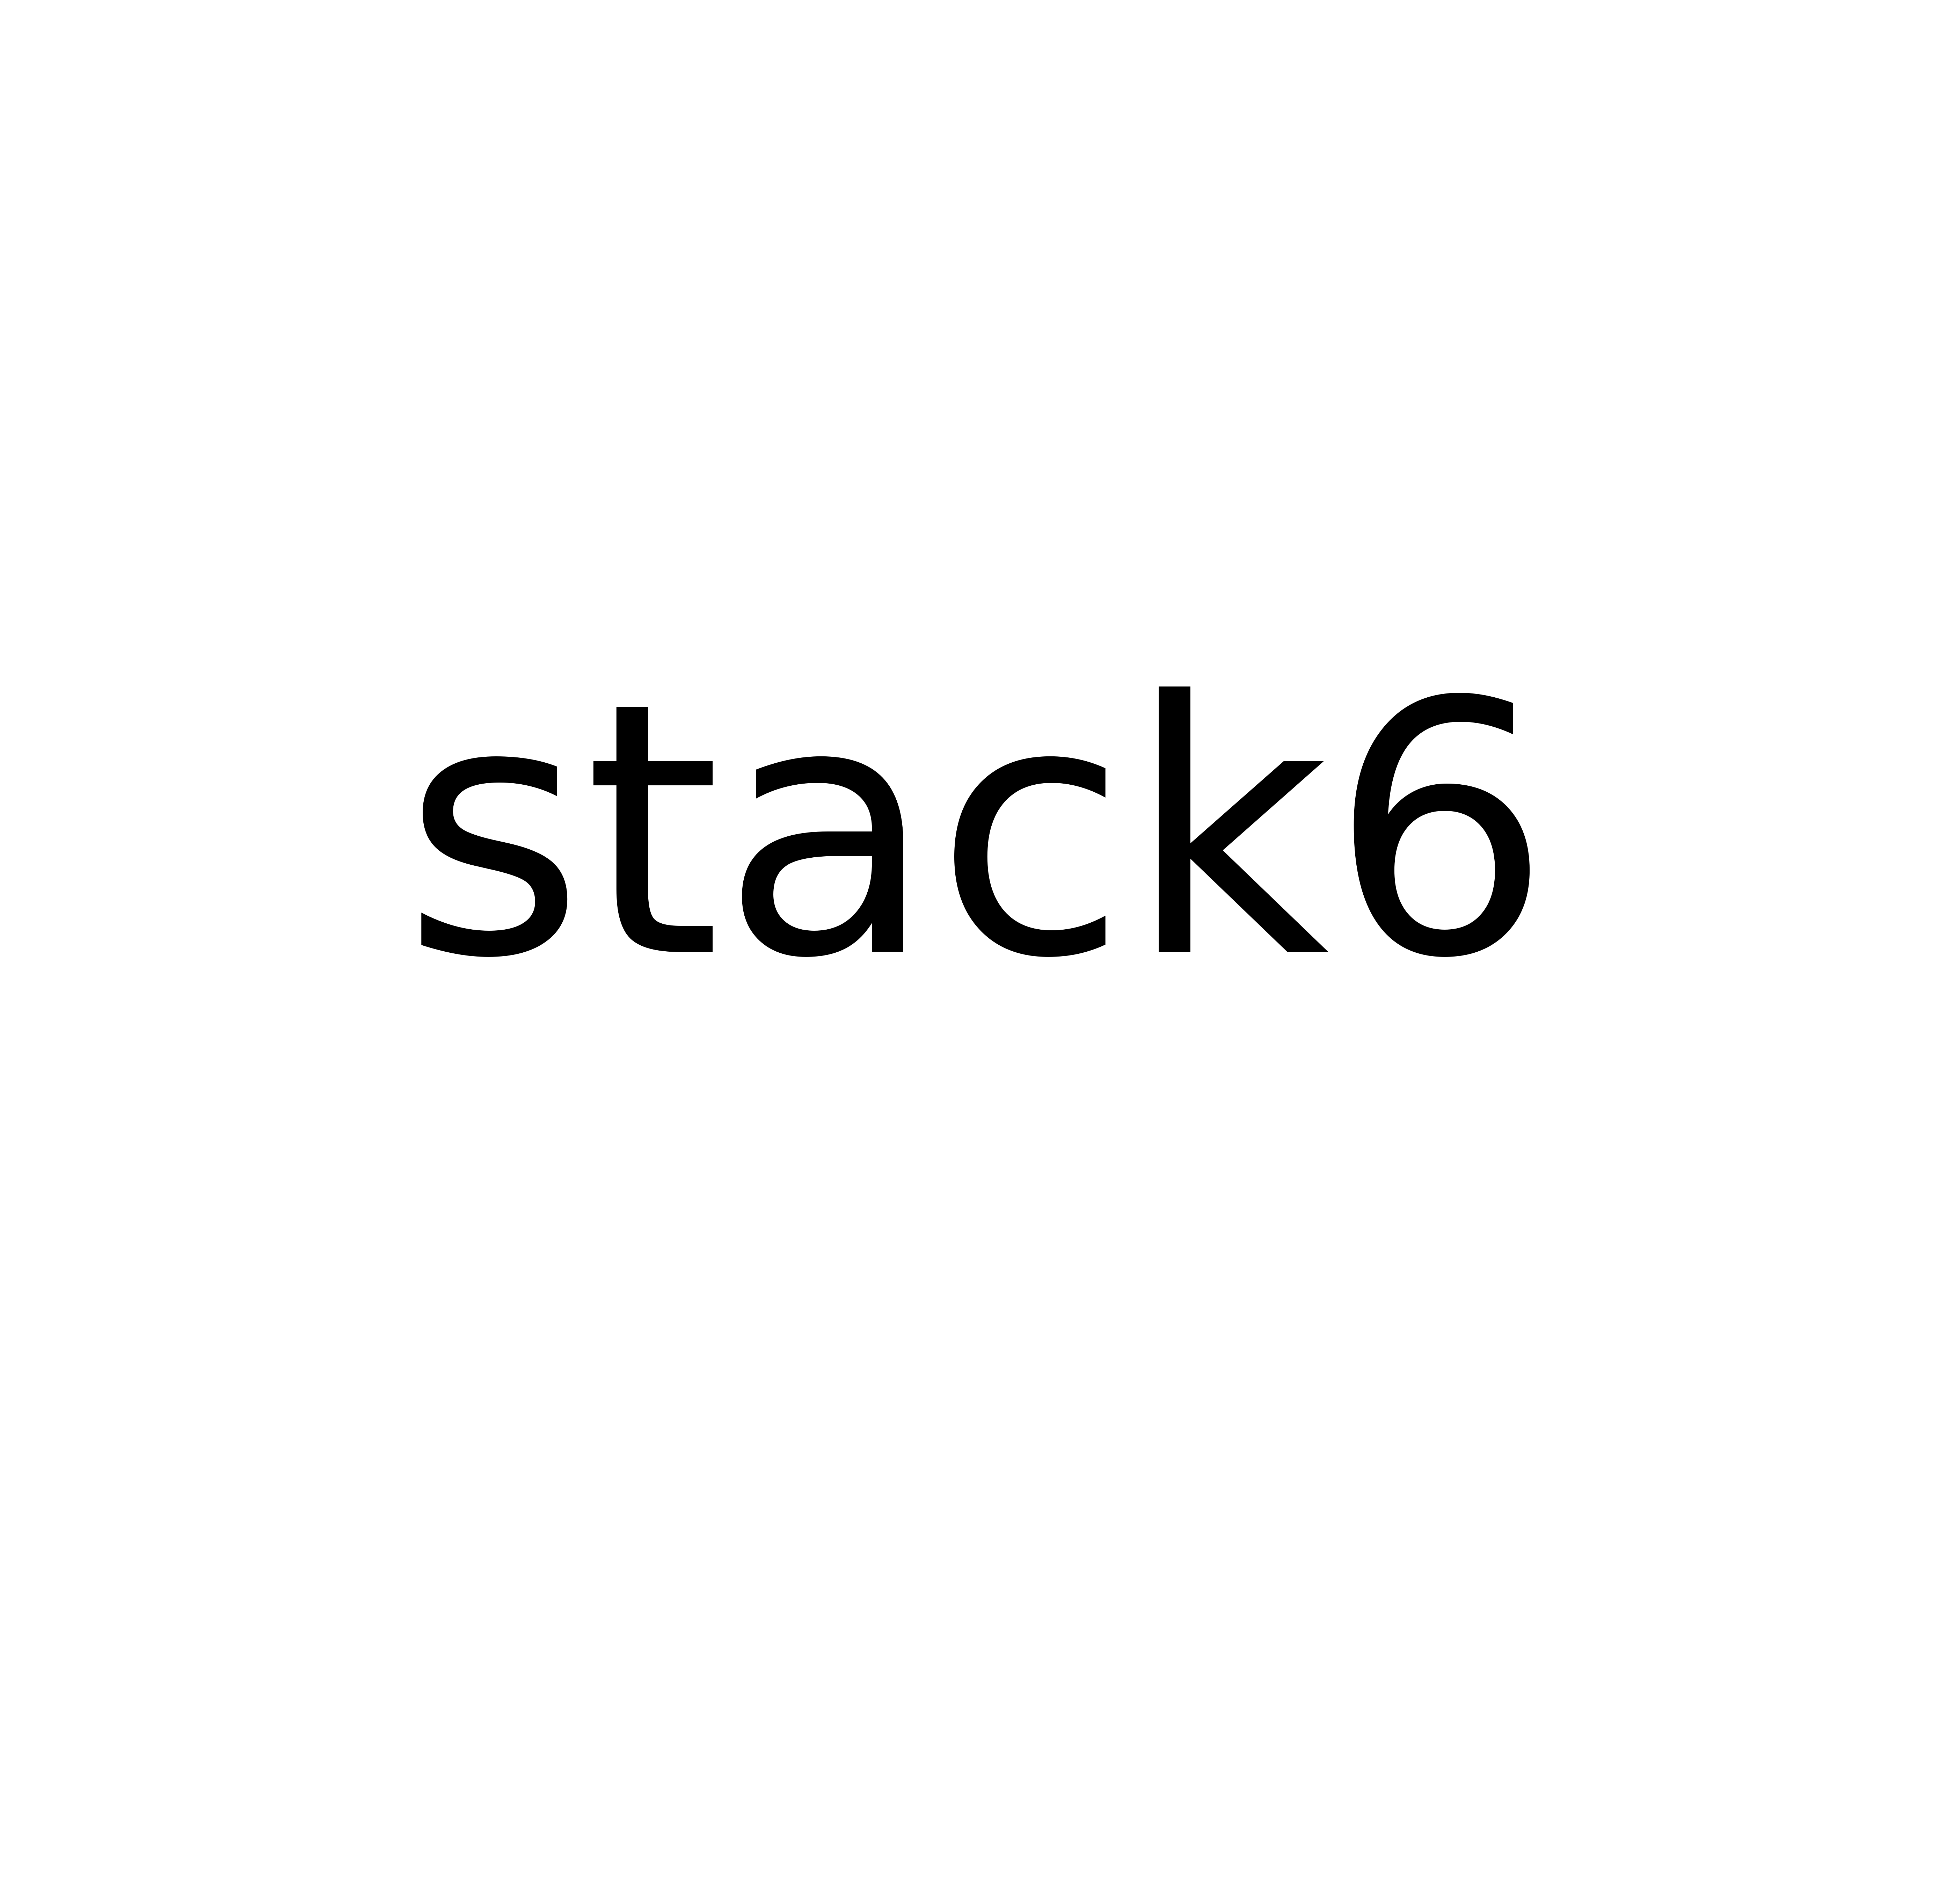

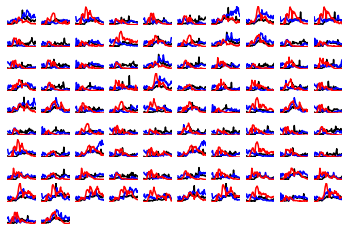

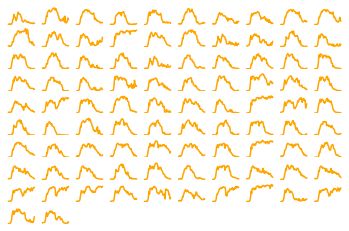

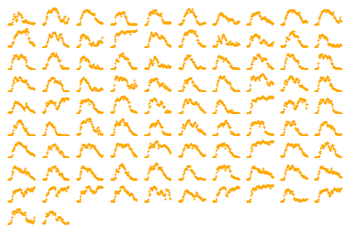

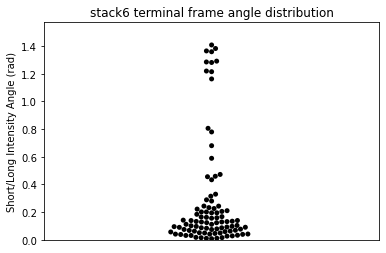

In [10]:
# make all plots for all cells
if allcell_plot:
    pltn = make_plots(stack_data, pltn)

Grab ICM cell IDs and fate calls:

In [11]:
# get the list of cells with called phenotypes
cells_called = []
with open(os.path.join(stack_directory, 'phenotypes.csv'), newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        s1 = row[0].replace("'", '')
        s1_1 = int(s1[0:s1.find('_')])
        s1_2 = int(s1[s1.find('_') + 1 : len(s1)])
        if exists(s1_1, s1_2):
            cells_called.append([s1_1, s1_2, row[1]])
cells_called = np.array(cells_called)

# make a list of called phenotypes
pheno = []
for i in range(len(cells_called)):
    if cells_called[i][2] not in pheno:
        pheno.append(cells_called[i][2])

# sort called cells by phenotype
pheno_data = []

for p in pheno:
    temp_cells = []

    for i in range(len(cells_called)):
        if cells_called[i][2] == p:
            temp_cells.append([int(cells_called[i][0]), int(cells_called[i][1])])

    temp_data = []
    for cell in temp_cells:
        temp_data.append([cell, express(transform(lineage(cell[0], cell[1])[0])), lineage(cell[0], cell[1])[1]])

    pheno_data.append([p, [given_stack + '-' + p, len(temp_data), temp_data]])

# ADD PHENO DATA PICKLING

Make phenotype plots:

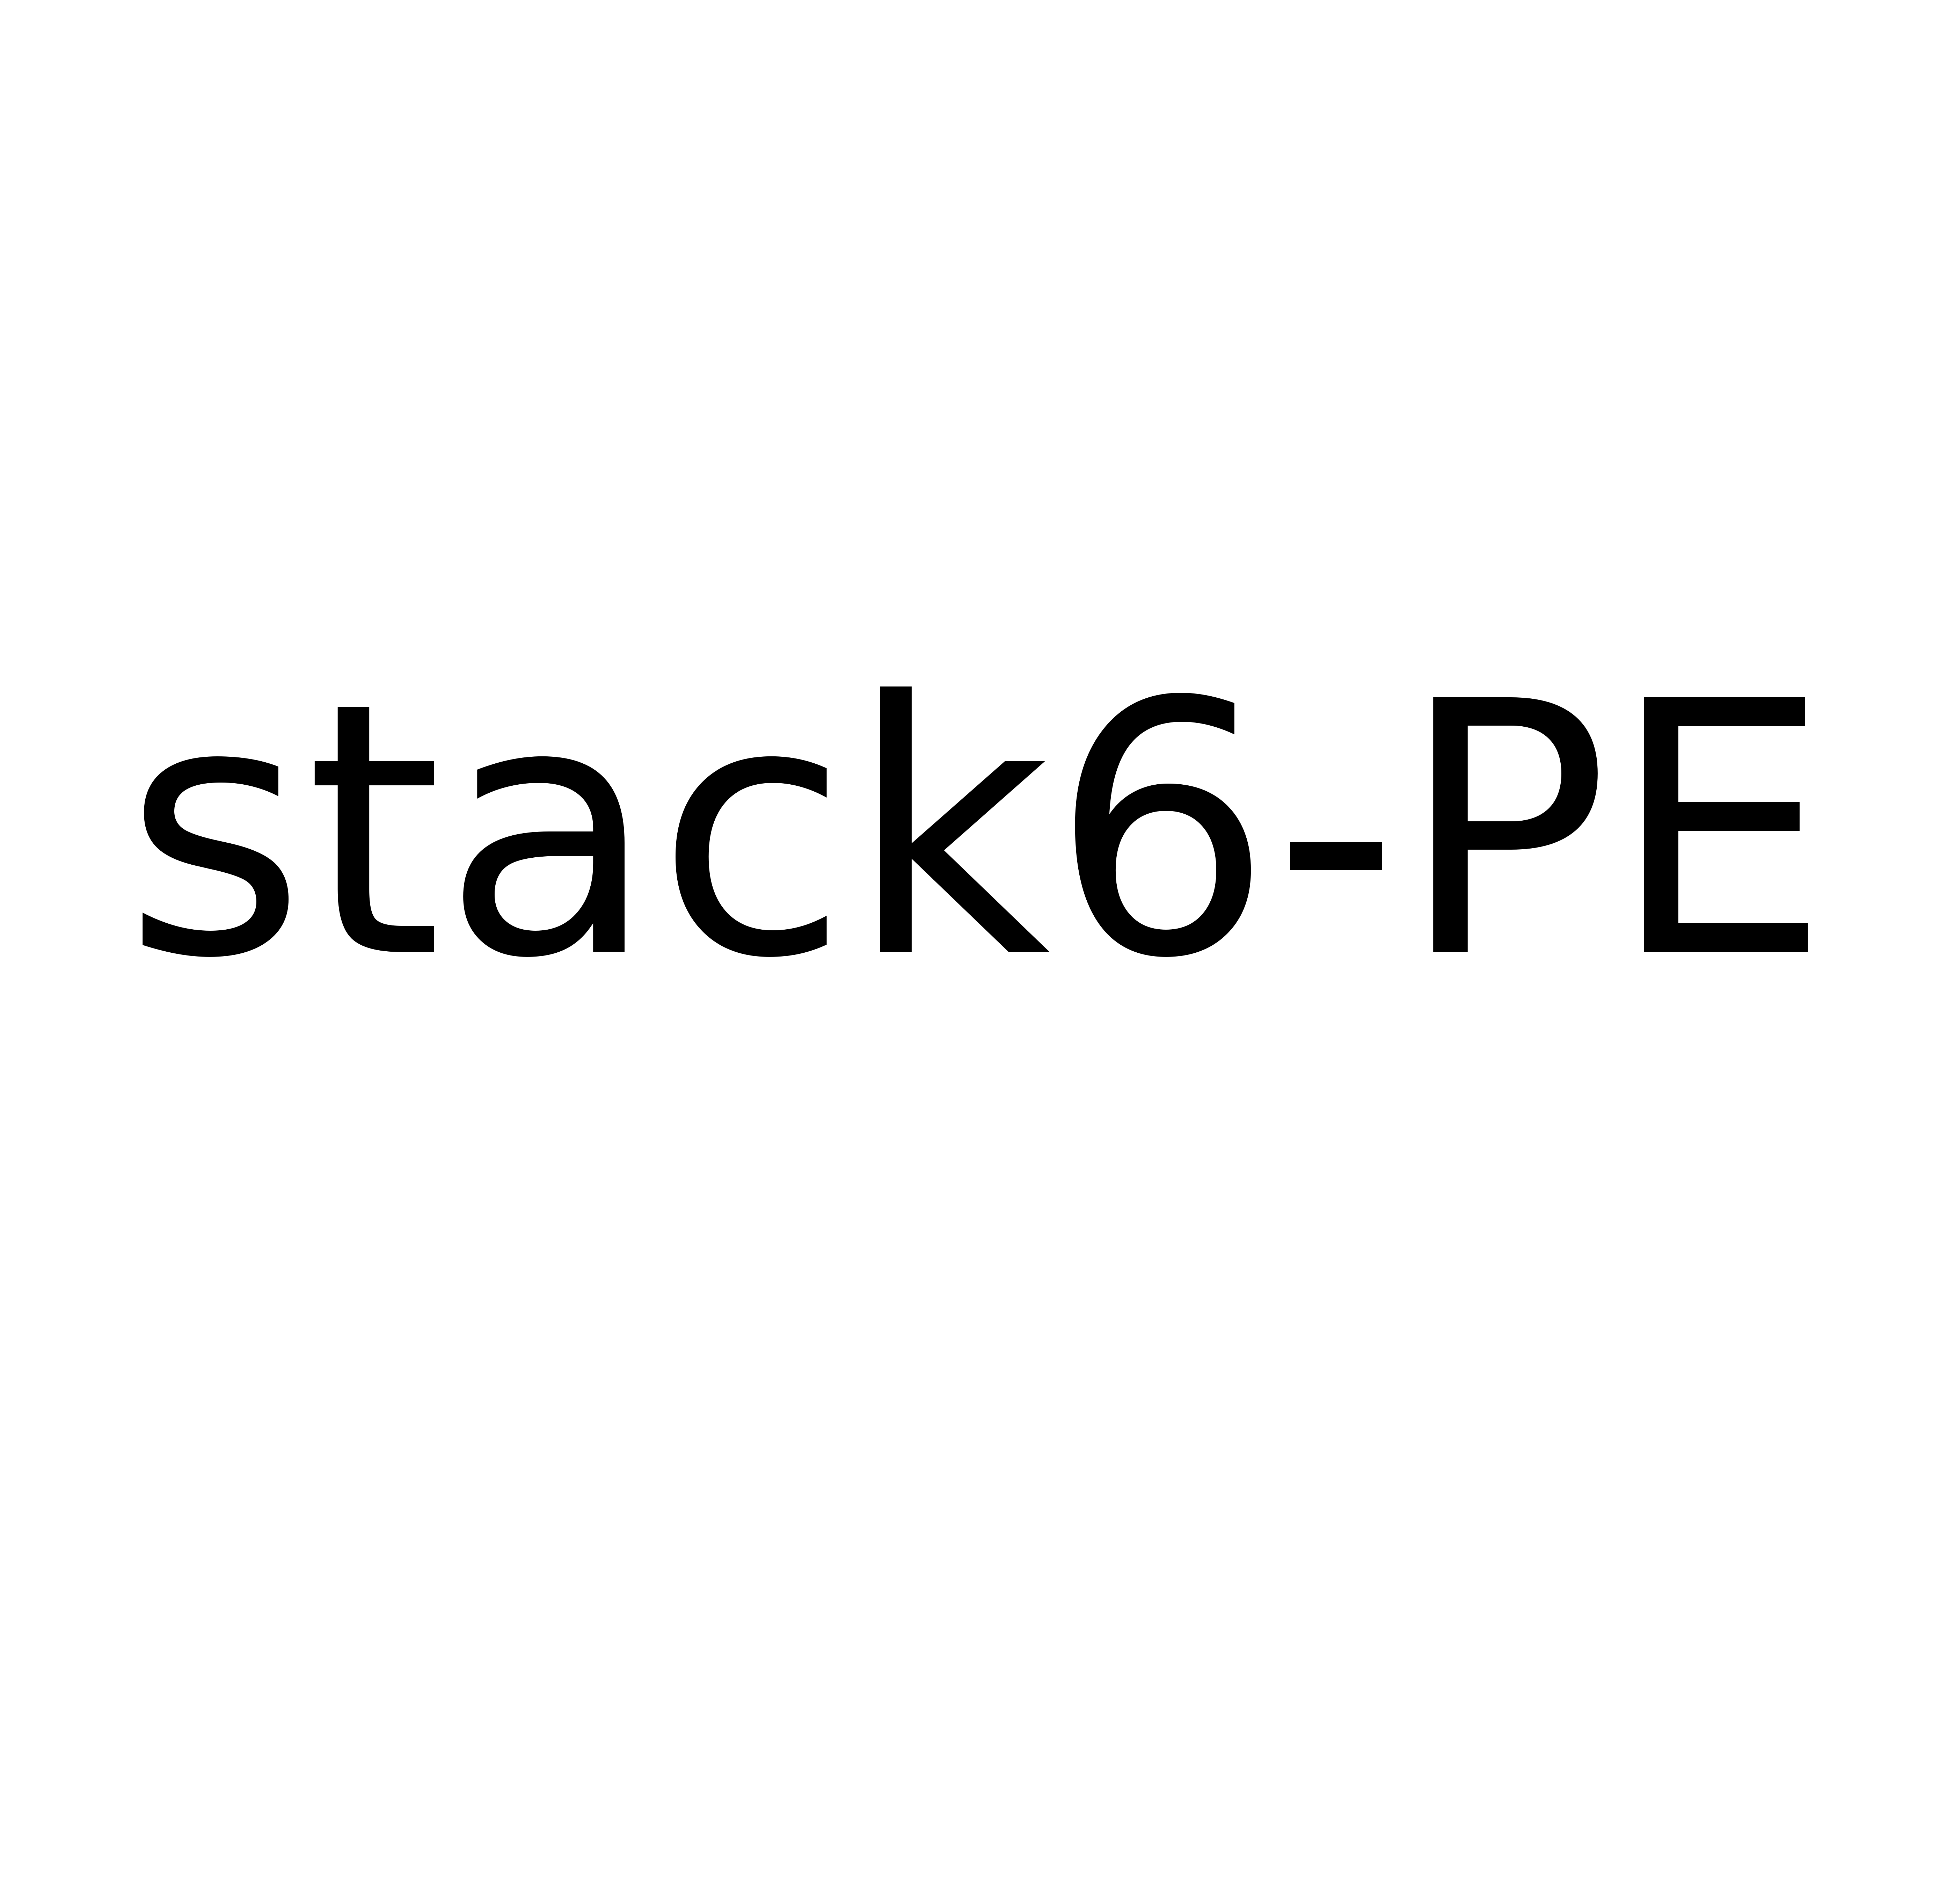

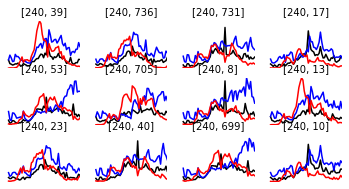

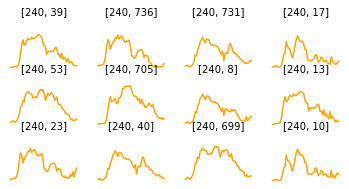

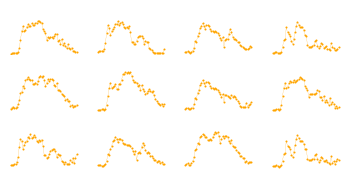

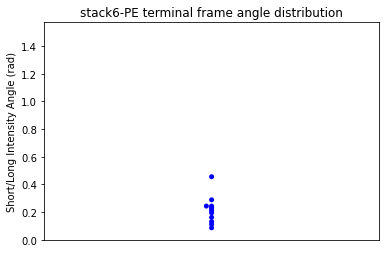

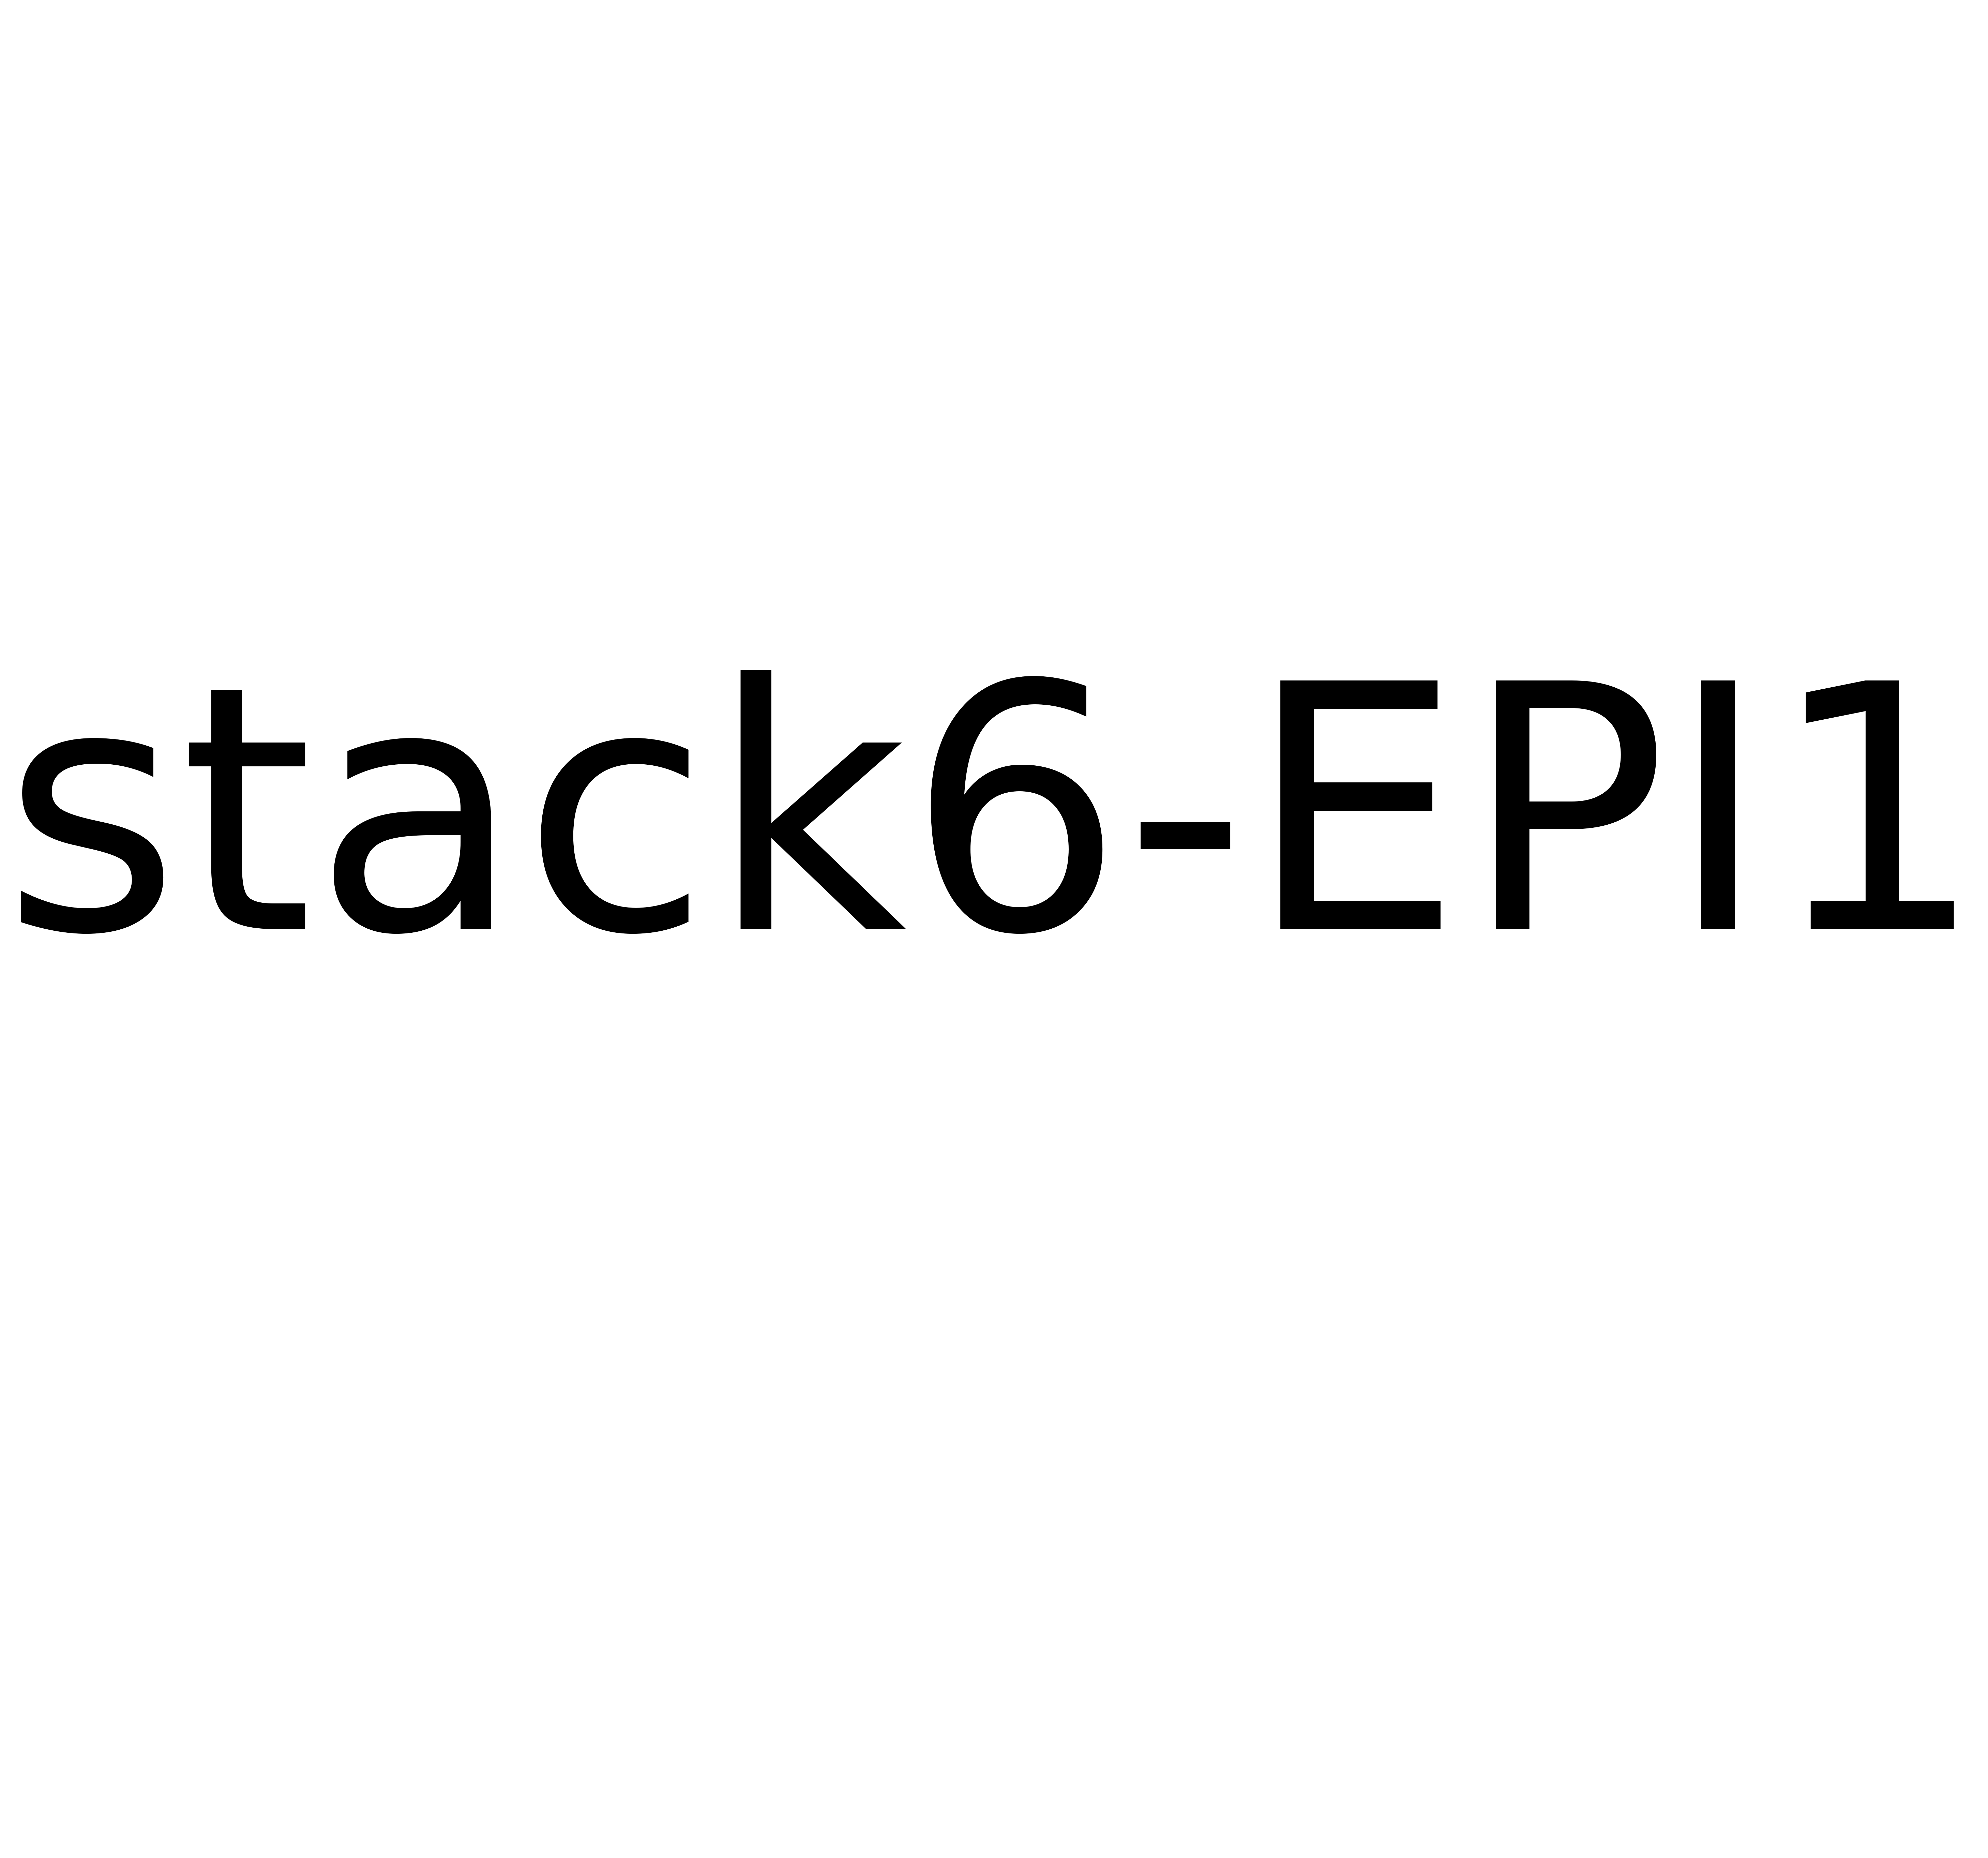

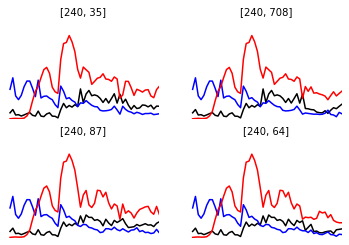

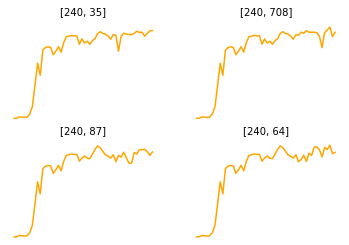

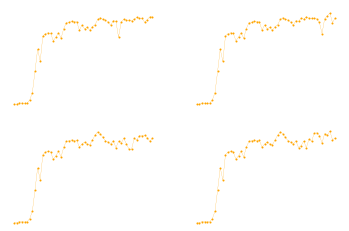

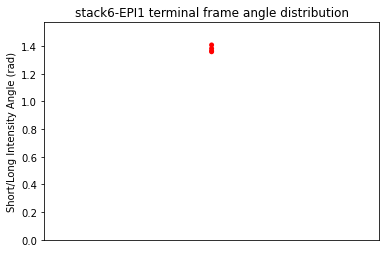

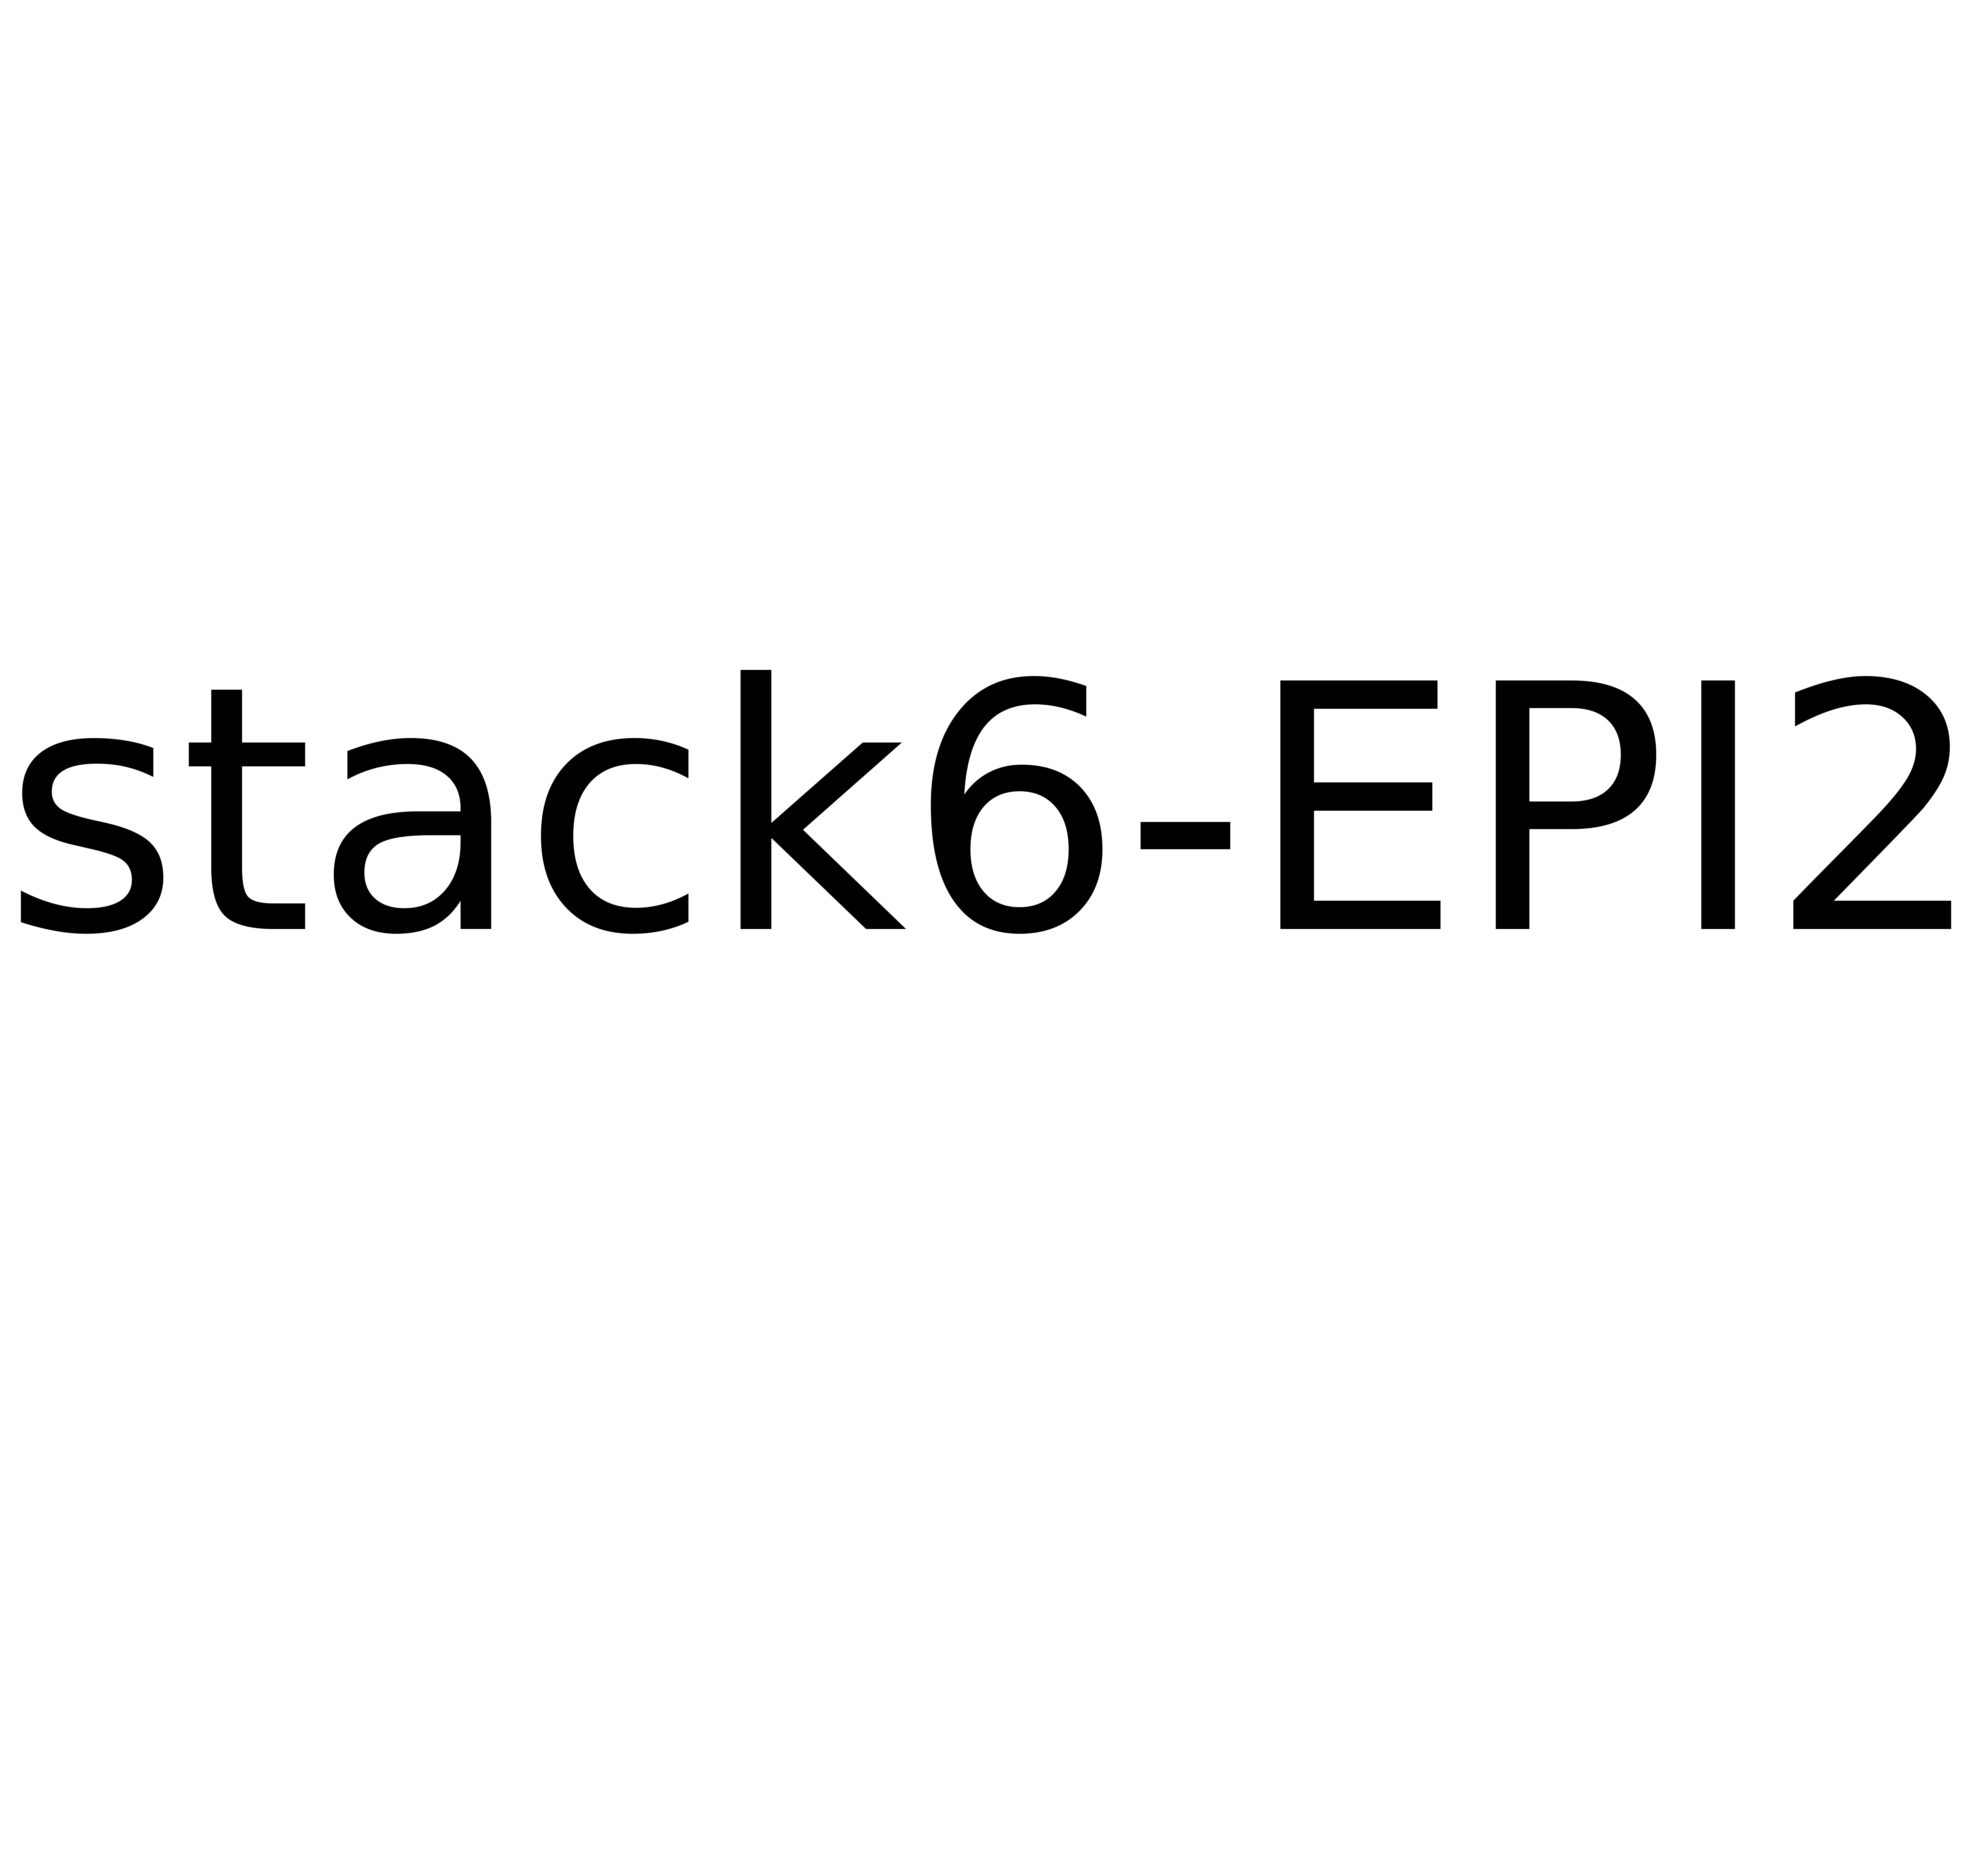

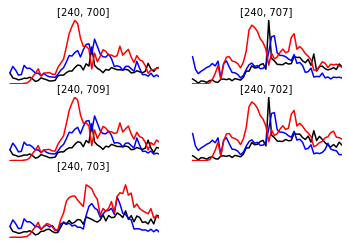

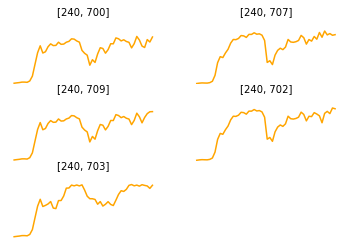

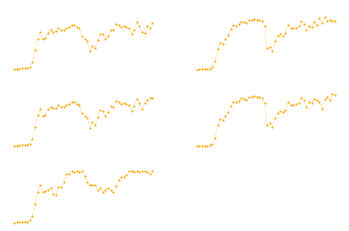

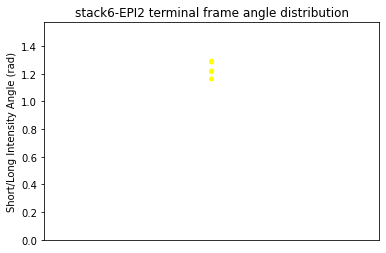

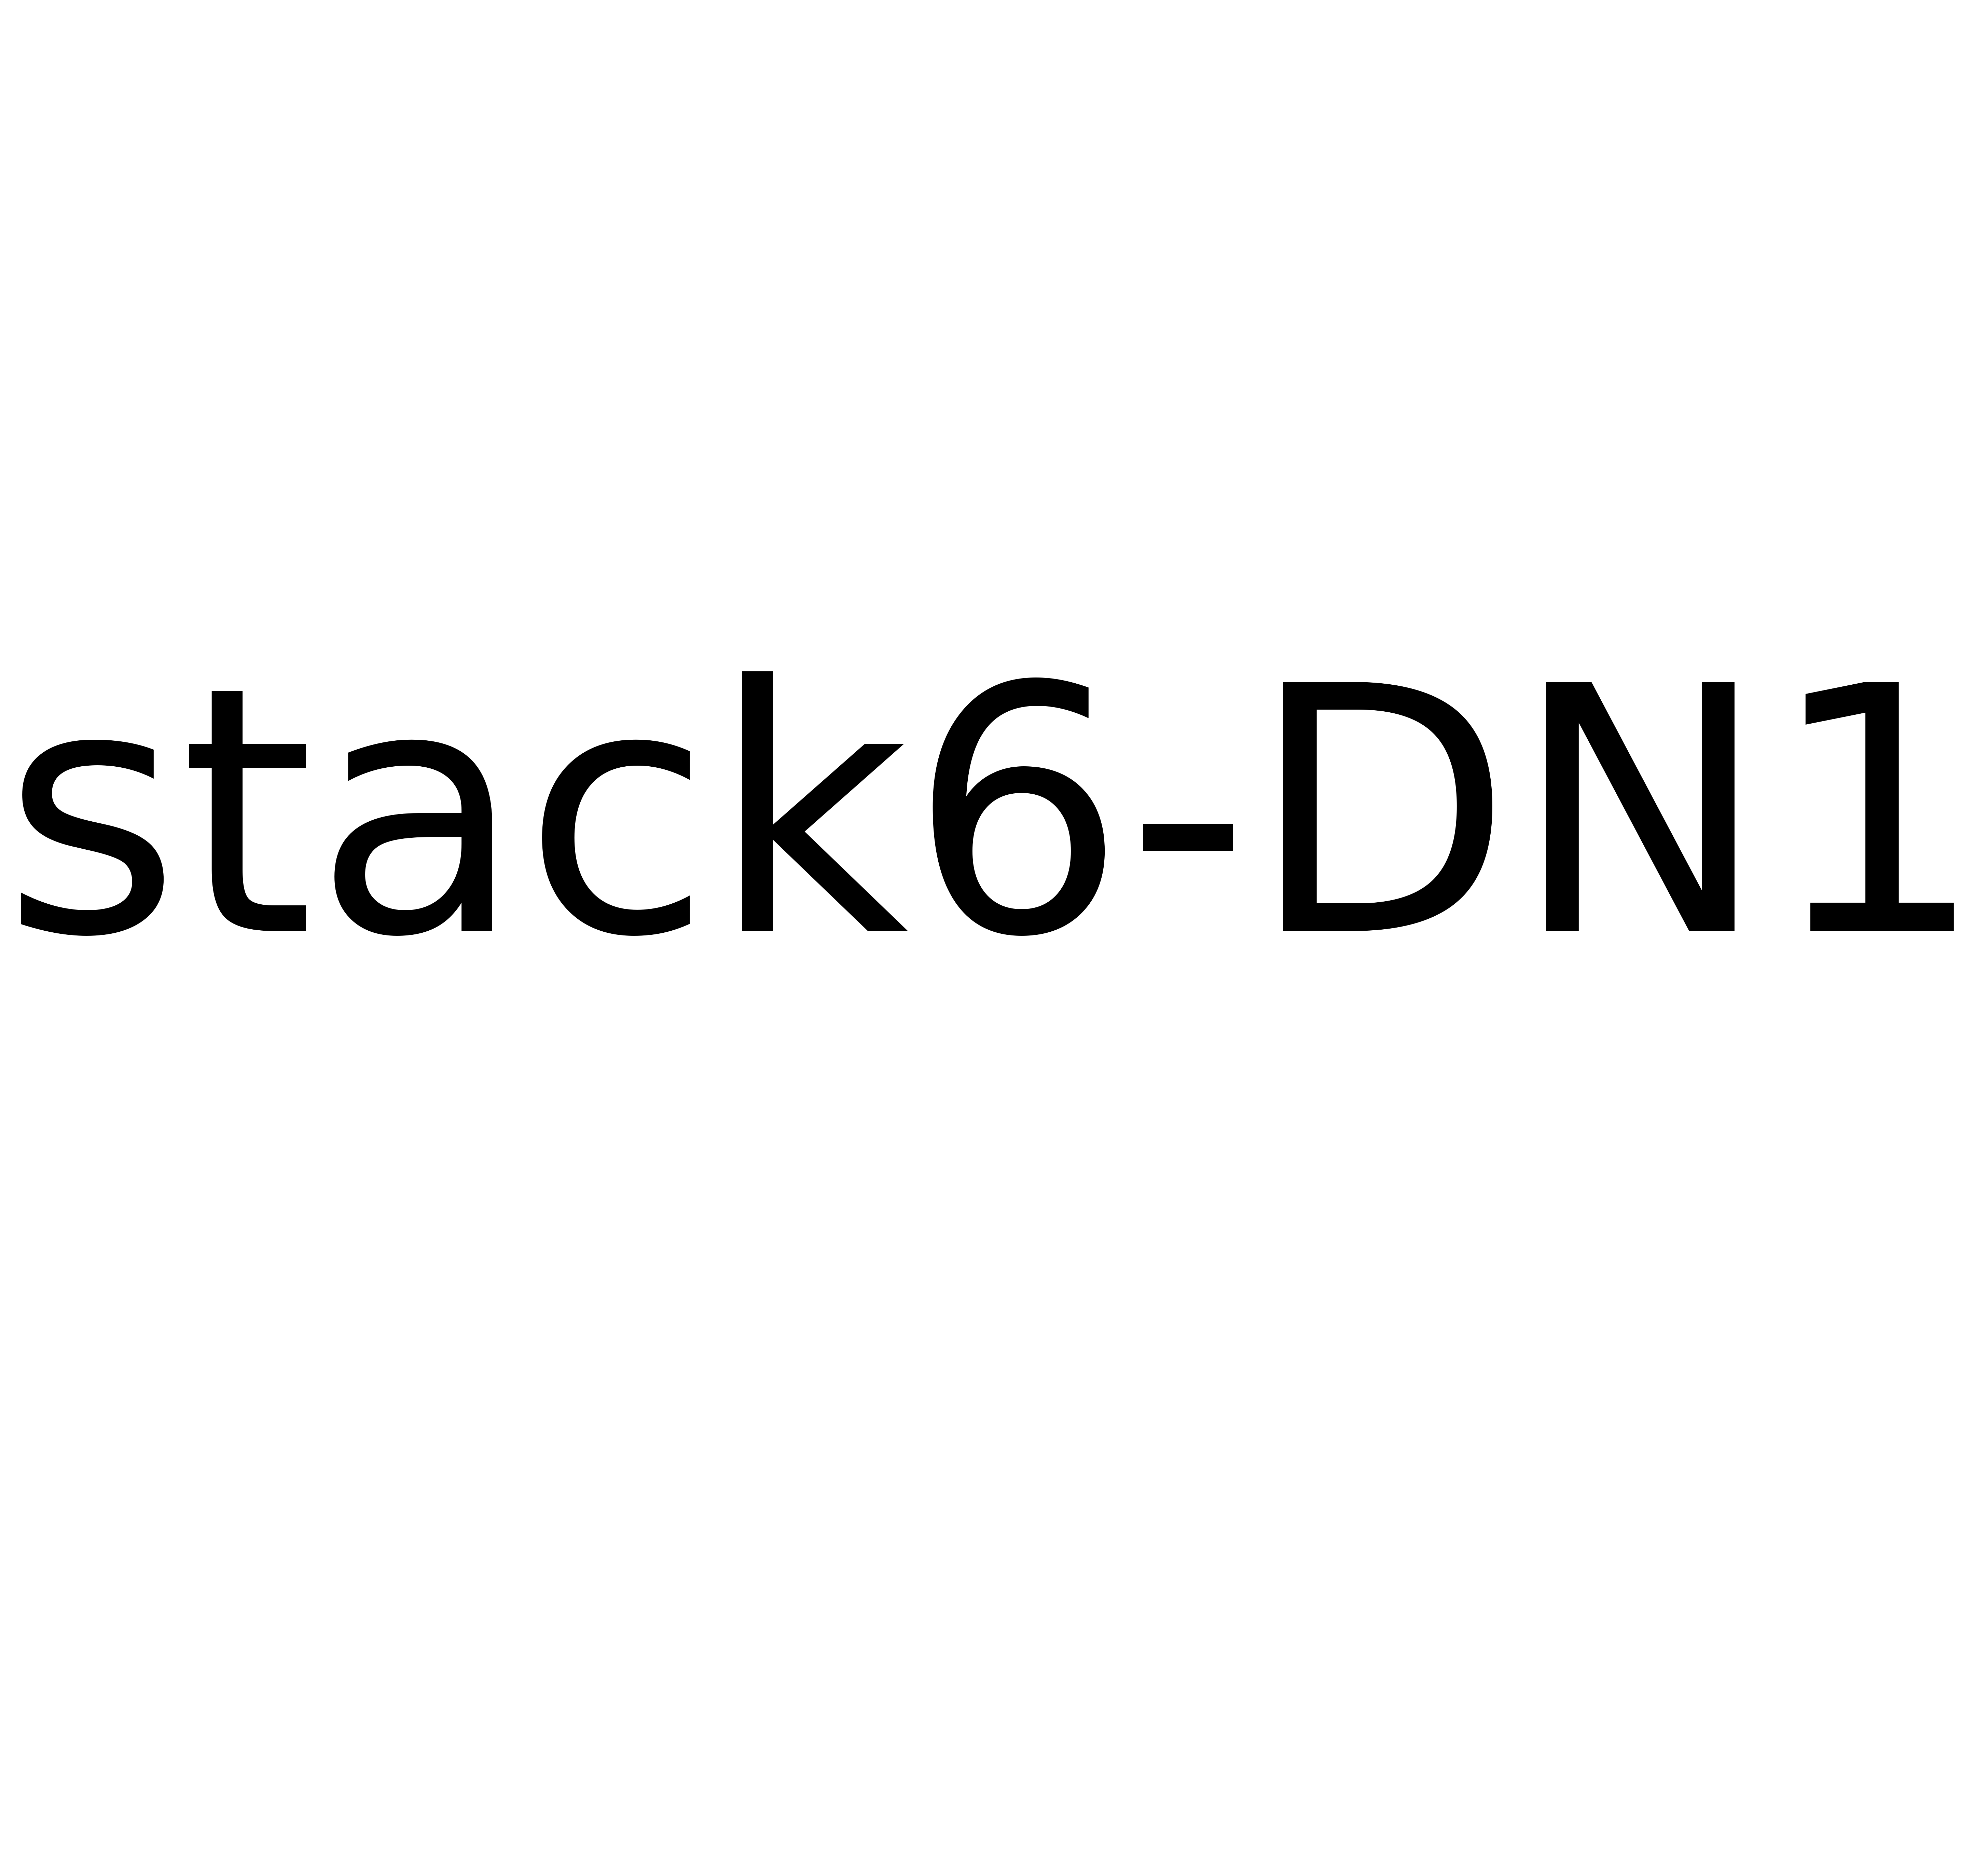

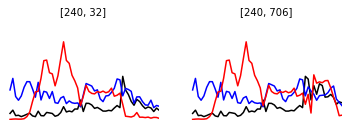

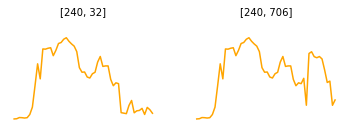

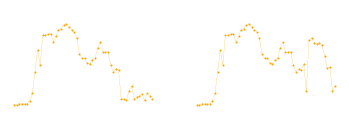

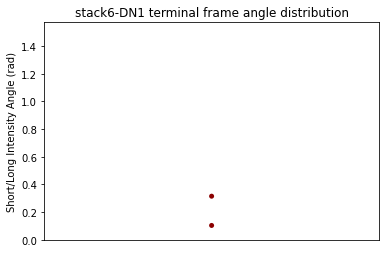

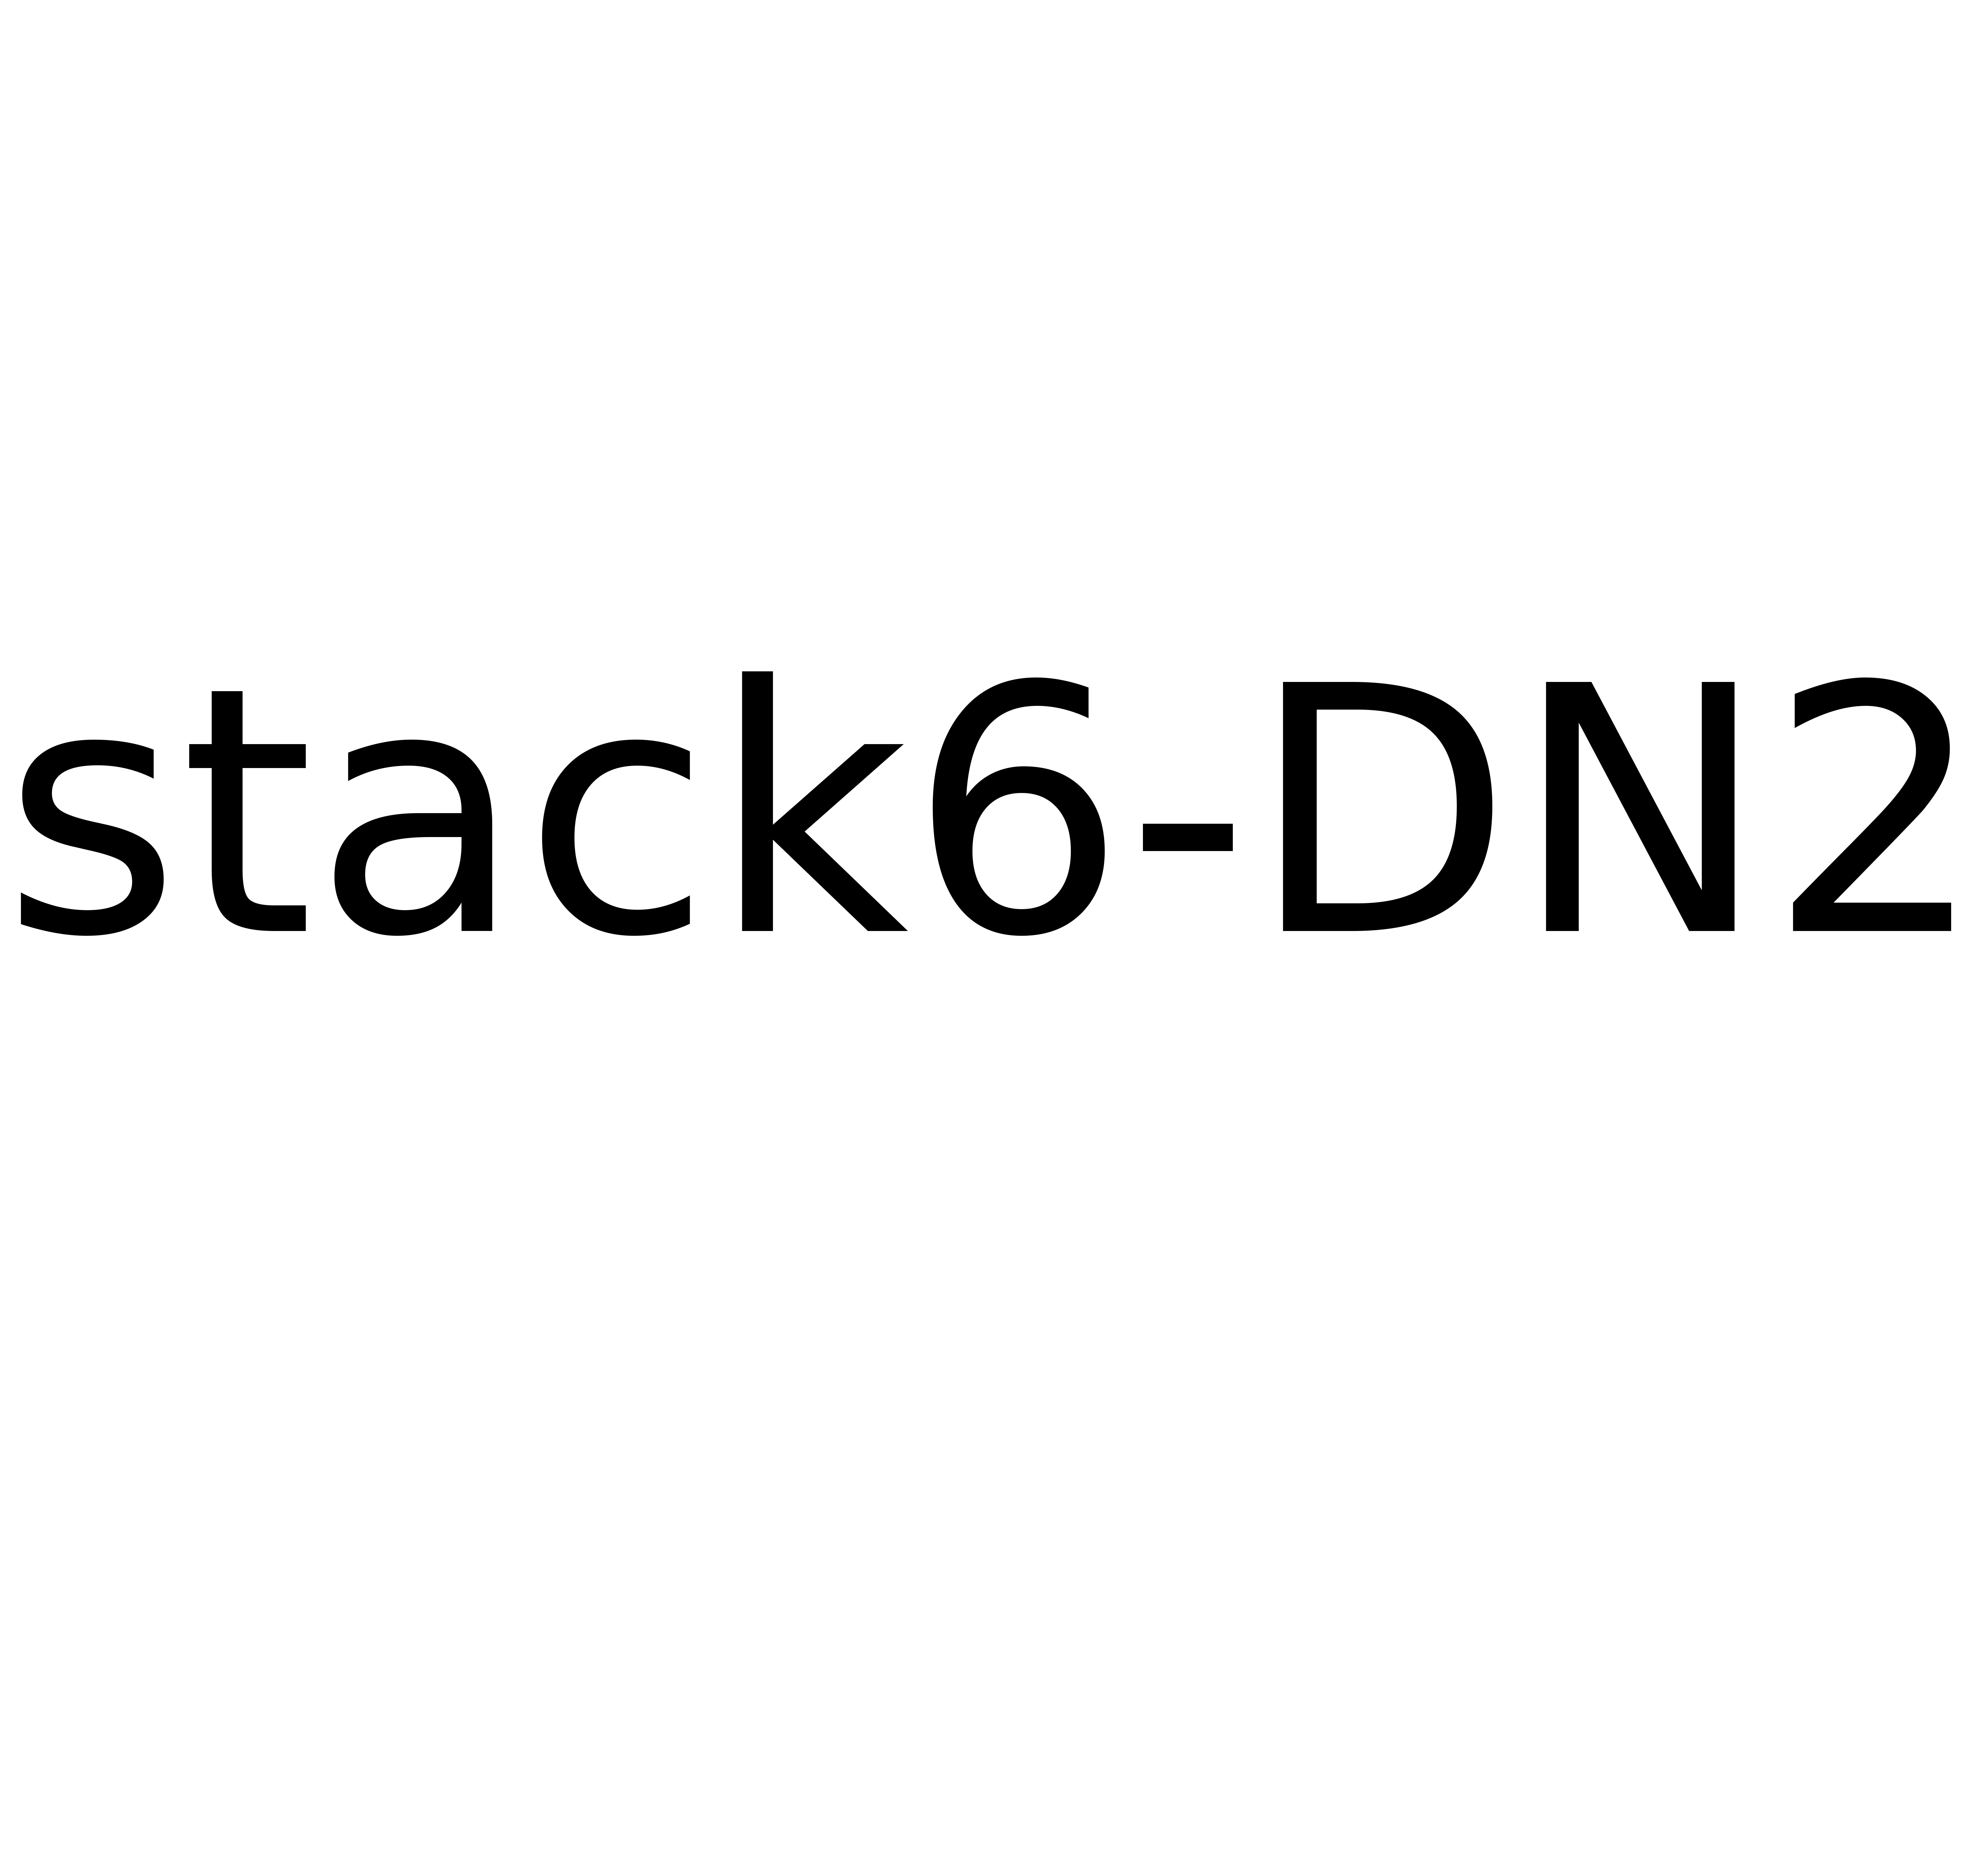

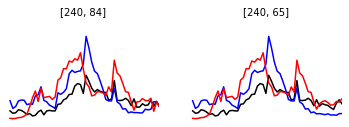

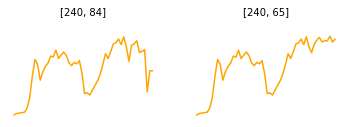

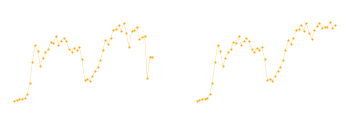

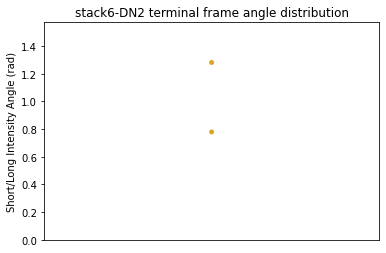

AttributeError: 'bool' object has no attribute 'all'

In [13]:
# make plots for each phenotype
for p in range(len(pheno)):
    pltn = make_plots(pheno_data[p][1], pltn)

deliniation_plot(given_stack + ' combined cell calls')

# plot the short-long angle of globally minmax-normallized intensity ratio distribution
for p in range(len(pheno)):
    stack = pheno_data[p][1]
    temp = []
    for i in range(stack[1]):
        temp.append(math.pi/2 - math.atan(((stack[2][i][1][len(stack[2][i][1]) - 1, 2] - blue_min)/(blue_max - blue_min)) / ((stack[2][i][1][len(stack[2][i][1])-1, 3] + 0.000001 - red_min)/(red_max - red_min))))

    sns.swarmplot(x = p, y = temp, color = colsel(pheno_data[p][0]), label = pheno_data[p][0])
plt.ylim(0, math.pi/2)
plt.title(given_stack + ' terminal frame angle distribution')
plt.ylabel('Short/Long Intensity Angle (rad)')
plt.xticks([])

if save_plots:
    name = str(pltn) + '.png'
    plt.savefig(os.path.join(plot_directory, name))
    pltn += 1

plt.show()

# plot the terminal frame globally minmax-normallized short vs long reporters
for p in range(len(pheno)):
    stack = pheno_data[p][1]
    for i in range(stack[1]):
        plt.scatter((stack[2][i][1][len(stack[2][i][1])-1, 2] - blue_min)/(blue_max - blue_min), (stack[2][i][1][len(stack[2][i][1])-1, 3] - red_min)/(red_max - red_min), s=dot_scale*(stack[2][i][1][len(stack[2][i][1])-1, 4] - black_min)/(black_max - black_min), c=colsel(pheno_data[p][0]), alpha=scatter_alpha, label = pheno_data[p][0])

plt.title(given_stack + ' terminal intensities of called cells')
plt.xlabel('Minmax-normalized Gata6')
plt.ylabel('Minmax-normalized Nanog')
plt.ylim(0, 1)
plt.xlim(0, 1)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

if save_plots:
    name = str(pltn) + '.png'
    plt.savefig(os.path.join(plot_directory, name))
    pltn += 1

plt.show()

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


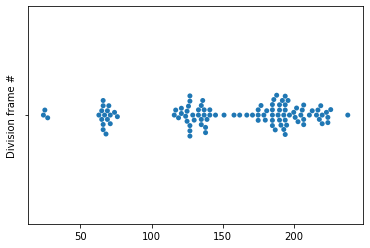

In [12]:
# show distribution of division frame
divs = []
for d in div:
    divs.append(d[0])
sns.swarmplot(divs)
plt.ylabel('Division frame #')
plt.show()

In [13]:
# show all divisions in fate-assigned cells
for p in pheno_data:
    for cell in p[1][2]:
        print(cell[2], '>', cell[0], p[0])

[[27, 14], [74, 20], [145, 55], [211, 76]] > [240, 39] PE
[[66, 11], [135, 41], [201, 90]] > [240, 736] PE
[[66, 13], [151, 22], [219, 42]] > [240, 731] PE
[[66, 15], [141, 53], [226, 35]] > [240, 732] PE
[[66, 15], [141, 53], [217, 7]] > [240, 17] PE
[[65, 5], [141, 39], [187, 173], [220, 41]] > [240, 53] PE
[[27, 14], [74, 20], [158, 47]] > [240, 705] PE
[[66, 13], [151, 22], [213, 60]] > [240, 8] PE
[[27, 14], [74, 20], [145, 55], [211, 76]] > [240, 13] PE
[[66, 11], [135, 41], [201, 90]] > [240, 23] PE
[[66, 13], [151, 22], [219, 42]] > [240, 40] PE
[[65, 5], [141, 39], [187, 173], [220, 41]] > [240, 699] PE
[[66, 15], [141, 53], [217, 7]] > [240, 10] PE
[[27, 14], [74, 20], [145, 55], [224, 2]] > [240, 700] EPI2
[[68, 18], [135, 46], [200, 35]] > [240, 707] EPI2
[[27, 14], [74, 20], [145, 55], [224, 2]] > [240, 709] EPI2
[[68, 18], [135, 46], [200, 35]] > [240, 702] EPI2
[[27, 14], [74, 20], [158, 47], [224, 56]] > [240, 703] EPI2
[[66, 11], [135, 41], [203, 45]] > [240, 84] EPI2


# # Gata6 vs Nanog analysis

In [14]:
def gata_threshold(data, gata_thresh = 0.5): # returns indexes of frames where gata6 first crosses a given threshold
    gata_indexes = []
    gata_frames = []

    for phenotype in data:
        for cell in phenotype[1][2]:
            found = False
            i = 0
            cens = []
            for d in cell[2]:
                for j in range(10):
                    cens.append(d[0] + j)
            while i < len(cell[1]) and not found:
                if (cell[1][i][2] - blue_min) / (blue_max - blue_min) >= gata_thresh and (cell[1][i][0] not in cens):
                    gata_indexes.append(i)
                    gata_frames.append(cell[1][i][0])
                    found = True
                else:
                    i += 1
            if not found:
                gata_indexes.append(-1)
                gata_frames.append(-1)
    
    return gata_indexes, gata_frames


In [15]:
gi, gf = gata_threshold(pheno_data, 0.65)

In [16]:
cnt = 0
cross = []
for p in pheno_data:
    for cell in p[1][2]:
        print(cell[0], p[0], '| Gata threshold crossed @', gf[cnt])
        if gf[cnt] > 0:
            cross.append(gf[cnt])
        cnt += 1

[240, 39] PE | Gata threshold crossed @ 184.0
[240, 736] PE | Gata threshold crossed @ 148.0
[240, 731] PE | Gata threshold crossed @ 184.0
[240, 732] PE | Gata threshold crossed @ 152.0
[240, 17] PE | Gata threshold crossed @ 176.0
[240, 53] PE | Gata threshold crossed @ 204.0
[240, 705] PE | Gata threshold crossed @ 180.0
[240, 8] PE | Gata threshold crossed @ 168.0
[240, 13] PE | Gata threshold crossed @ 184.0
[240, 23] PE | Gata threshold crossed @ 148.0
[240, 40] PE | Gata threshold crossed @ 184.0
[240, 699] PE | Gata threshold crossed @ 204.0
[240, 10] PE | Gata threshold crossed @ 176.0
[240, 700] EPI2 | Gata threshold crossed @ -1
[240, 707] EPI2 | Gata threshold crossed @ -1
[240, 709] EPI2 | Gata threshold crossed @ -1
[240, 702] EPI2 | Gata threshold crossed @ -1
[240, 703] EPI2 | Gata threshold crossed @ -1
[240, 84] EPI2 | Gata threshold crossed @ -1
[240, 65] EPI2 | Gata threshold crossed @ -1
[240, 32] EPI1 | Gata threshold crossed @ -1
[240, 706] EPI1 | Gata threshold 

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


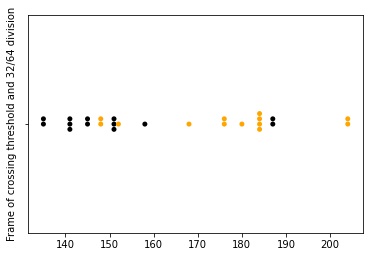

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


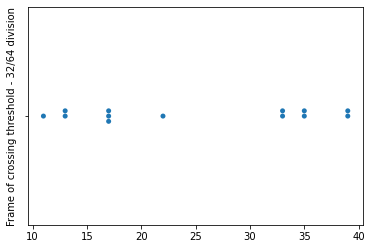

In [17]:
cnt = 0
cross_divs = []
for p in pheno_data:
    for cell in p[1][2]:
        if gf[cnt] > 0:
            d = cell[2][len(cell[2])-1][0]
            if d != 158:
                d = cell[2][len(cell[2])-2][0]
            cross_divs.append(d)
        cnt+=1
        
sns.swarmplot(cross_divs, color='black')        
sns.swarmplot(cross, color='orange')
plt.ylabel("Frame of crossing threshold and 32/64 division")
plt.show()

sns.swarmplot(np.array(cross)-np.array(cross_divs))
plt.ylabel("Frame of crossing threshold - 32/64 division")
plt.show()

In [18]:
def threshold_distributions(crosses): # gathers statistics of what cells did or didn't cross the threshold
    cnt = 0
    counts = []
    norm = []
    for p in pheno_data:
        tmp = 0
        for cell in p[1][2]:
            if crosses[cnt] > 0:
                tmp += 1
            cnt += 1
        counts.append(tmp)
        norm.append(tmp / len(p[1][2]))
    
    return counts, norm

In [19]:
c, n = threshold_distributions(gf)

In [20]:
print(pheno)
print(c)
print(n)

['PE', 'EPI2', 'EPI1']
[13, 0, 0]
[1.0, 0.0, 0.0]


In [21]:
def nanog_linreg(data, gata_ids, steps = 20): # fits a slope to nanog trace following gata6 threshold
    peaks = []
    nonpeaks = []
    
    cnt = 0
    for phenotype in data:
        for cell in phenotype[1][2]:
            nanog = []
            frame = []
            if gata_ids[cnt] > 0:
                for i in range(gata_ids[cnt], min(gata_ids[cnt] + steps, len(cell[1])), 1):
                    nanog.append(cell[1][i][2])
                    frame.append(cell[1][i][0])
                peaks.append(scipy.stats.linregress(frame, nanog).slope)
            else:
                d = cell[2][len(cell[2])-1][0]
                if d != 158:
                    d = cell[2][len(cell[2])-2][0]
                found = False
                tmp = -1
                while not found:
                    tmp += 1
                    if d - cell[1][tmp][0] < 4:
                        found = True
                for i in range(tmp, min(tmp + steps, len(cell[1])), 1):
                    nanog.append(cell[1][i][2])
                    frame.append(cell[1][i][0])
                nonpeaks.append(scipy.stats.linregress(frame, nanog).slope)
            
            cnt += 1
    
    return peaks, nonpeaks
 

In [22]:
ns, ni = nanog_linreg(pheno_data, gi)

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


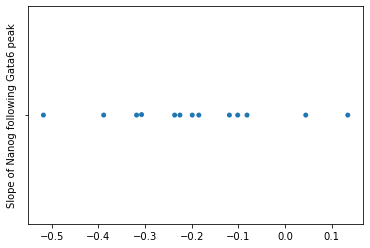

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


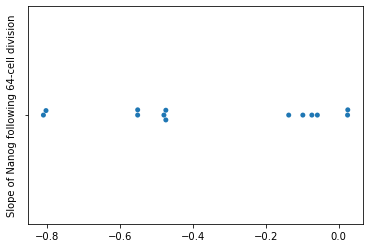

In [23]:
sns.swarmplot(ns)
plt.ylabel("Slope of Nanog following Gata6 peak")
plt.show()
sns.swarmplot(ni)
plt.ylabel("Slope of Nanog following 64-cell division")
plt.show()

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning

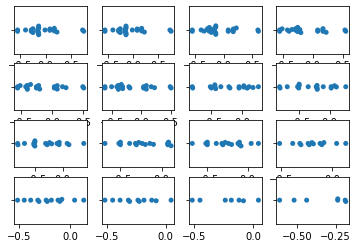

In [24]:
start_thresh = 0.35
end_thresh = 0.75
fine = 15
avgs = []
threshs = []
stdevs = []
Ns = []
counts = []
norms = []
for t in range(fine + 1):
    N, M = minimal_rectangle(fine)
    plt.subplot(N, M, t + 1)
    t0 = start_thresh + (end_thresh - start_thresh) * t / fine
    t1, t2 = gata_threshold(pheno_data, t0)
    t3, t4 = nanog_linreg(pheno_data, t1)
    c, n = threshold_distributions(t2)
    counts.append(c)
    norms.append(n)
    avgs.append(np.mean(t3))
    stdevs.append(np.std(t3))
    threshs.append(t0)
    Ns.append(len(t3))
    sns.swarmplot(t3)
    plt.ylim(-2, 2)
plt.show()

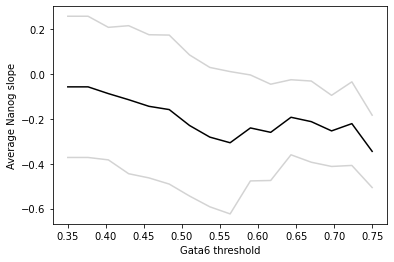

In [25]:
upper = []
lower = []
for i in range(len(avgs)):
    upper.append(avgs[i] + stdevs[i])
    lower.append(avgs[i] - stdevs[i])
plt.plot(threshs, avgs, color='black')
plt.plot(threshs, upper, color='lightgrey')
plt.plot(threshs, lower, color='lightgrey')
plt.xlabel('Gata6 threshold')
plt.ylabel('Average Nanog slope')
plt.show()

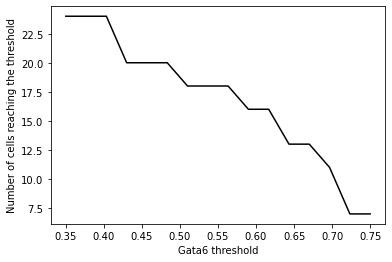

In [26]:
plt.plot(threshs, Ns, color="black")
plt.xlabel('Gata6 threshold')
plt.ylabel('Number of cells reaching the threshold')
plt.show()

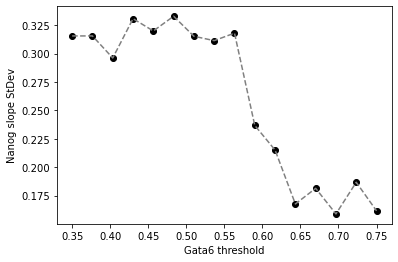

In [27]:
plt.scatter(threshs, stdevs, color="black")
plt.plot(threshs, stdevs, color="grey", linestyle='dashed')
plt.xlabel('Gata6 threshold')
plt.ylabel('Nanog slope StDev')
plt.show()

In [ ]:
print(counts)

In [ ]:
print(norms)

In [28]:
def count_transpose(data): # transposes and formats counts or norms variable for plotting
    out = []
    for i in range(len(data[0])):
        out.append([])
    
    for point in data:
        for i in range(len(point)):
            out[i].append(point[i])
    
    for i in range(len(out)):
        out[i] = np.array(out[i])
        
    return out


In [29]:
tcount = count_transpose(counts)
print(tcount)

[array([13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 11,  7,  7]), array([7, 7, 7, 7, 7, 7, 5, 5, 5, 3, 3, 0, 0, 0, 0, 0]), array([6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]


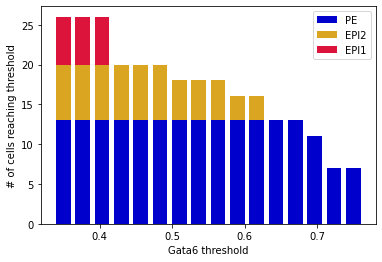

In [30]:
for i in range(len(pheno)):
    if i == 0:
        plt.bar(np.array(threshs), tcount[i], color=colsel(pheno[i]), align='center', width=0.02, label=pheno[i])
    else:
        bot = np.zeros(len(tcount[0]))
        for j in range(i):
            bot += tcount[j]
        plt.bar(np.array(threshs), tcount[i], bottom=bot, color=colsel(pheno[i]), align='center', width=0.02, label=pheno[i])
plt.xlabel('Gata6 threshold')
plt.ylabel('# of cells reaching threshold')
plt.legend()
plt.show()

In [31]:
tnorm = count_transpose(norms)
print(tnorm)

[array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.84615385, 0.53846154,
       0.53846154]), array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.71428571, 0.71428571, 0.71428571, 0.42857143,
       0.42857143, 0.        , 0.        , 0.        , 0.        ,
       0.        ]), array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]


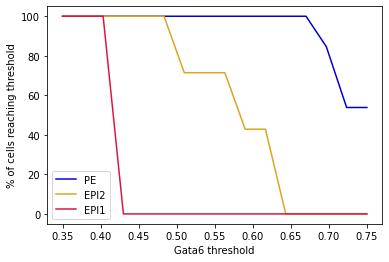

In [32]:
for i in range(len(pheno)):
    plt.plot(np.array(threshs), 100*tnorm[i], color=colsel(pheno[i]), label=pheno[i])
plt.xlabel('Gata6 threshold')
plt.ylabel('% of cells reaching threshold')
plt.legend()
plt.show()

# Test of building trees in Python

In [78]:
from treelib import Node, Tree

In [83]:
def name(cell): # converts [frame, ID] of a cell to a string 'frame_ID'
    return str(cell[0]) + '_' + str(cell[1])

In [129]:
lineages = []
successes = 0
fails = 0
for i in range(len(track)):
    edge = track[i]
    if edge[0][0] == start_frame: # create new tree if mother is in the starting frame
        lineages.append(Tree())
        lineages[len(lineages)-1].create_node(name(edge[0]), name(edge[0]))
        lineages[len(lineages)-1].create_node(name(edge[1]), name(edge[1]), parent=name(edge[0]))
    else:
        i = 0
        found = False
        while i < len(lineages) and not found:
            try:
                lineages[i].create_node(name(edge[1]), name(edge[1]), parent=name(edge[0]))
                found = True
            except:
                i += 1
                found = False
        if not found:
            print('Edge ' + name(edge[0]) + ' - ' + name(edge[1]) + ' failed to join')
            fails += 1
        else:
            successes += 1

print("Total successfull edges:", successes)            
print("Total failed edges:", fails)

Edge 185_16 - 186_50 failed to join
Edge 185_60 - 186_54 failed to join
Edge 200_31 - 201_65 failed to join
Edge 201_65 - 202_61 failed to join
Edge 202_61 - 203_23 failed to join
Edge 203_23 - 204_77 failed to join
Edge 204_77 - 205_62 failed to join
Edge 205_62 - 206_425 failed to join
Edge 205_87 - 206_10 failed to join
Edge 206_10 - 207_64 failed to join
Edge 206_425 - 207_74 failed to join
Edge 207_64 - 208_54 failed to join
Edge 207_74 - 208_72 failed to join
Edge 208_54 - 209_98 failed to join
Edge 208_72 - 209_81 failed to join
Edge 209_81 - 210_88 failed to join
Edge 209_98 - 210_87 failed to join
Edge 210_87 - 211_43 failed to join
Edge 210_88 - 211_448 failed to join
Edge 211_43 - 212_82 failed to join
Edge 211_448 - 212_83 failed to join
Edge 212_82 - 213_88 failed to join
Edge 212_83 - 213_84 failed to join
Edge 213_84 - 214_83 failed to join
Edge 213_88 - 214_40 failed to join
Edge 214_28 - 215_30 failed to join
Edge 214_40 - 215_88 failed to join
Edge 214_83 - 215_72 fai

In [120]:
lineages[1].show()

24_2
└── 25_5
    └── 26_17
        └── 27_14
            ├── 28_10
            │   └── 29_3
            │       └── 30_7
            │           └── 31_8
            │               └── 32_4
            │                   └── 33_3
            │                       └── 34_13
            │                           └── 35_9
            │                               └── 36_6
            │                                   └── 37_2
            │                                       └── 38_8
            │                                           └── 39_8
            │                                               └── 40_17
            │                                                   └── 41_17
            │                                                       └── 42_12
            │                                                           └── 43_15
            │                                                               └── 44_16
            │                                 

In [124]:
lineages[1].save2file('tree.txt')

# Test of making scatter plot GIFs

In [14]:
from matplotlib.animation import FuncAnimation
from matplotlib.collections import PathCollection

In [15]:
print(pheno_data[0][1][2][0][1][0])

[ 28.           3.         134.40708851 120.50489795 218.44121547]


In [16]:
gata6s = []
nanogs = []
cols = []
framenum = []
ICMsize = []

for i in range(len(pheno_data[0][1][2][0][1])):
    g_temp = []
    n_temp = []
    c_temp = []
    cell_list = []
    for p in pheno_data:
        for cell in p[1][2]:
            cell_name = str(int(cell[1][i][0])) + '_' + str(int(cell[1][i][1]))
            if cell_name not in cell_list:
                g_temp.append((cell[1][i][2] - blue_min) / (blue_max - blue_min + 0.00001))
                n_temp.append((cell[1][i][3] - red_min) / (red_max - red_min + 0.00001))
                c_temp.append(colsel(p[0]))
                cell_list.append(cell_name)
    gata6s.append(g_temp)
    nanogs.append(n_temp)
    cols.append(c_temp)
    framenum.append(int(cell[1][i][0]))
    ICMsize.append(len(cell_list))

In [17]:
print(ICMsize)

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 11, 11, 12, 13, 14, 14, 15, 15, 15, 15, 15, 15, 15, 17, 18, 18, 18, 21, 21, 22, 22, 24, 25, 26, 26, 26, 26]


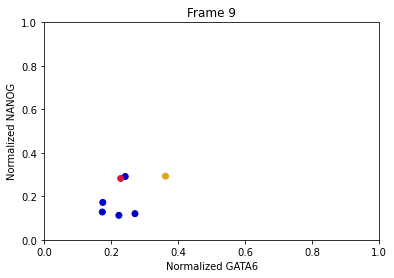

In [18]:
frame_temp = 9
plt.scatter(gata6s[frame_temp], nanogs[frame_temp], color = cols[frame_temp])
plt.xlabel('Normalized GATA6')
plt.xlim(0, 1)
plt.ylabel('Normalized NANOG')
plt.ylim(0, 1)
plt.title('Frame ' + str(frame_temp))
plt.show()

In [38]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

fade = 1
frame_rate = 2.5

blank_gata = []
blank_nanog = []

ax.scatter(blank_gata, blank_nanog)

scatters: list[PathCollection] = []
    
def update(frame):
    for scatter in scatters: # remove previous scatter plots
        scatter.remove()
    scatters.clear()
    
    scatter = []

    for f in range(max(0, frame - fade), frame):
        scatter = ax.scatter(gata6s[f], nanogs[f], color = cols[f], alpha = (frame - f) ** 2 / (fade + 0.0001) ** 2)
        scatters.append(scatter)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Normalized GATA6")
    ax.set_ylabel("Normalized NANOG")
    timepoint = (framenum[frame] - start_frame) / 4
    ax.set_title('Frame: ' + str(framenum[frame]) + '; Elapsed hours: ' + f"{timepoint:.1f}" + ' ; ICM size: ' + str(ICMsize[frame]))

    return scatters

gif = FuncAnimation(fig, update, frames = len(gata6s), repeat = False)
gif.save('test.gif', fps = frame_rate, writer = "pillow")
plt.close(fig)

In [19]:
for p in pheno_data:
    for cell in p[1][2]:
        print(cell[2], '>', cell[0], p[0])

[[27, 14], [74, 20], [145, 55], [211, 76]] > [240, 39] PE
[[66, 11], [135, 41], [201, 90]] > [240, 736] PE
[[66, 13], [151, 22], [219, 42]] > [240, 731] PE
[[66, 15], [141, 53], [226, 35]] > [240, 732] PE
[[66, 15], [141, 53], [217, 7]] > [240, 17] PE
[[65, 5], [141, 39], [187, 173], [220, 41]] > [240, 53] PE
[[27, 14], [74, 20], [158, 47]] > [240, 705] PE
[[66, 13], [151, 22], [213, 60]] > [240, 8] PE
[[27, 14], [74, 20], [145, 55], [211, 76]] > [240, 13] PE
[[66, 11], [135, 41], [201, 90]] > [240, 23] PE
[[66, 13], [151, 22], [219, 42]] > [240, 40] PE
[[65, 5], [141, 39], [187, 173], [220, 41]] > [240, 699] PE
[[66, 15], [141, 53], [217, 7]] > [240, 10] PE
[[27, 14], [74, 20], [145, 55], [224, 2]] > [240, 700] EPI2
[[68, 18], [135, 46], [200, 35]] > [240, 707] EPI2
[[27, 14], [74, 20], [145, 55], [224, 2]] > [240, 709] EPI2
[[68, 18], [135, 46], [200, 35]] > [240, 702] EPI2
[[27, 14], [74, 20], [158, 47], [224, 56]] > [240, 703] EPI2
[[66, 11], [135, 41], [203, 45]] > [240, 84] EPI2


In [20]:
gif_directory = os.path.join(plot_directory, 'GIFs')
if not os.path.exists(gif_directory):
        os.mkdir(gif_directory)

In [21]:
def trajectory_gif(cell, hps = 1, cl = 'black', interpol = 1): # generates a GIF of a cell's trajectory on the GATA6-NANOG plot
    gata6s = []
    nanogs = []
    framenum = []
    eltime = []
    start = int(cell[1][0][0])
    cell_name = str(cell[0][0]) + '_' + str(cell[0][1])
    hour_per_index = (int(cell[1][1][0]) - int(cell[1][0][0])) / 4
    
    for timepoint in cell[1]:
        gata6s.append((timepoint[2] - blue_min) / (blue_max - blue_min + 0.00001))
        nanogs.append((timepoint[3] - red_min) / (red_max - red_min + 0.00001))
        framenum.append(int(timepoint[0]))
        eltime.append((timepoint[0] - start) / 4)
    
    if interpol > 1:
        tmp_gata6s = [gata6s[0]]
        tmp_nanogs = [nanogs[0]]
        tmp_framenum = [framenum[0]]
        tmp_eltime = [eltime[0]]
        
        for i in range(len(gata6s) - 1):
            dg = gata6s[i + 1] - gata6s[i]
            dn = nanogs[i + 1] - nanogs[i]
            dt = eltime[i + 1] - eltime[i]
            for j in range(interpol):
                tmp_gata6s.append(gata6s[i] + dg * (j + 1) / interpol)
                tmp_nanogs.append(nanogs[i] + dn * (j + 1) / interpol)
                tmp_framenum.append(framenum[i])
                tmp_eltime.append(eltime[i] + dn * (j + 1) / interpol)
        
        gata6s = tmp_gata6s
        nanogs = tmp_nanogs
        framenum = tmp_framenum
        eltime = tmp_eltime
    
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

    blank_gata = []
    blank_nanog = []
    ax.scatter(blank_gata, blank_nanog)
    scatters: list[PathCollection] = []

    def update(frame):
        for scatter in scatters: # remove previous scatter plots
            scatter = []
        scatters.clear()

        scatter = []
        scatter = ax.plot(gata6s[0:frame], nanogs[0:frame], color = cl, marker = "o", markersize = 5 / interpol, linewidth = 2 / interpol)
        scatters.append(scatter)

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel("Normalized GATA6")
        ax.set_ylabel("Normalized NANOG")
        ax.set_title('Cell ID: ' + cell_name + '; Frame: ' + str(framenum[frame]) + '; Time: ' + f"{eltime[frame]:.1f}" + 'h')

        return scatters
    
    gif = FuncAnimation(fig, update, frames = len(gata6s), repeat = False)
    
    if interpol == 1:
        gif_name = cell_name + '.gif'
    else:
        gif_name = 'int' + str(interpol) + "-" + cell_name + '.gif'
    
    gif.save(os.path.join(gif_directory, gif_name), fps = hps * hour_per_index * interpol, writer = "pillow")
    plt.close(fig)

In [96]:
trajectory_gif(pheno_data[2][1][2][3], 2.5, colsel(pheno[2]))

In [27]:
trajectory_gif(pheno_data[0][1][2][3], 2.5, colsel(pheno[0]), 5)

KeyboardInterrupt: 

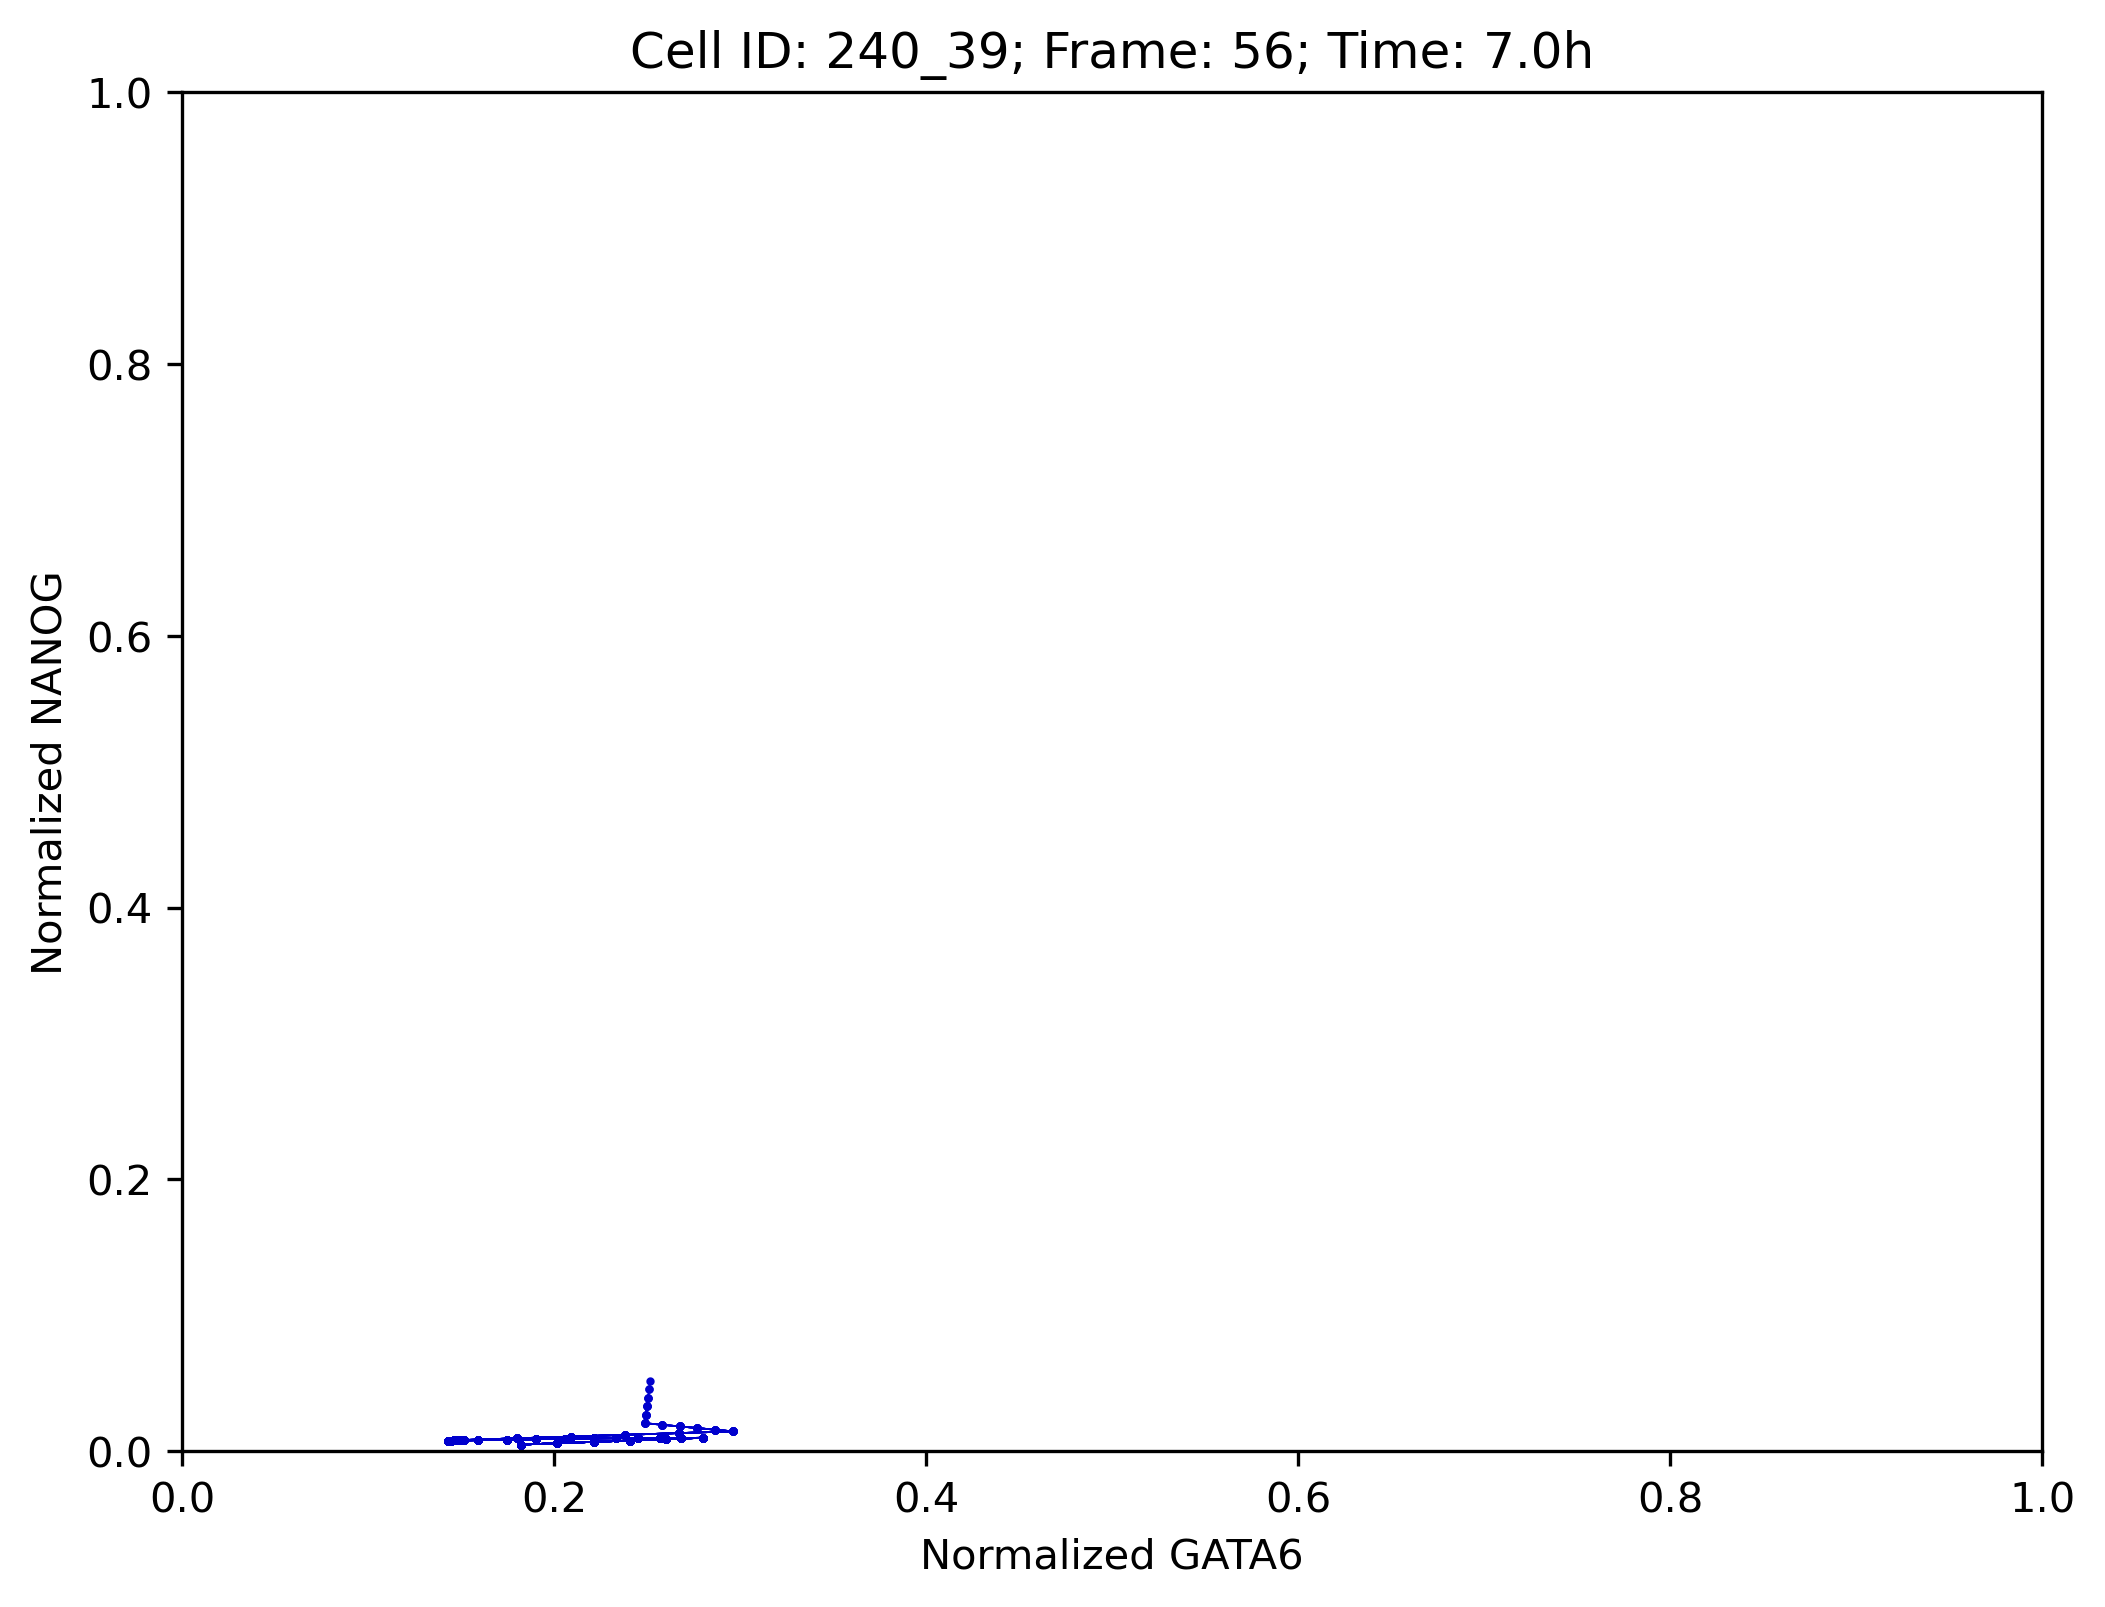

In [95]:
for p in pheno_data:
    for cell in p[1][2]:
        trajectory_gif(cell, 2.5, colsel(p[0]), 5)
        print('Finished making GIF for cell ' + str(cell[0][0]) + '_' + str(cell[0][1]))

In [22]:
def trajectories_gif(cell_list, hps = 1, interpol = 1): # generates a GIF of a the trajectories of a list of cells on the GATA6-NANOG plot
    g6s = []
    ns = []
    fs = []
    ts = []
    fates = []
    
    for cell_tuple in cell_list:
        cell = cell_tuple[0]
        fate = cell_tuple[1]
        
        gata6s = []
        nanogs = []
        framenum = []
        eltime = []
        start = int(cell[1][0][0])
        cell_name = str(cell[0][0]) + '_' + str(cell[0][1])
        hour_per_index = (int(cell[1][1][0]) - int(cell[1][0][0])) / 4

        for timepoint in cell[1]:
            gata6s.append((timepoint[2] - blue_min) / (blue_max - blue_min + 0.00001))
            nanogs.append((timepoint[3] - red_min) / (red_max - red_min + 0.00001))
            framenum.append(int(timepoint[0]))
            eltime.append((timepoint[0] - start) / 4)

        if interpol > 1:
            tmp_gata6s = [gata6s[0]]
            tmp_nanogs = [nanogs[0]]
            tmp_framenum = [framenum[0]]
            tmp_eltime = [eltime[0]]

            for i in range(len(gata6s) - 1):
                dg = gata6s[i + 1] - gata6s[i]
                dn = nanogs[i + 1] - nanogs[i]
                dt = eltime[i + 1] - eltime[i]
                for j in range(interpol):
                    tmp_gata6s.append(gata6s[i] + dg * (j + 1) / interpol)
                    tmp_nanogs.append(nanogs[i] + dn * (j + 1) / interpol)
                    tmp_framenum.append(framenum[i])
                    tmp_eltime.append(eltime[i] + dn * (j + 1) / interpol)

            gata6s = tmp_gata6s
            nanogs = tmp_nanogs
            framenum = tmp_framenum
            eltime = tmp_eltime
        
        g6s.append(gata6s)
        ns.append(nanogs)
        fs.append(framenum)
        ts.append(eltime)
        fates.append(fate)
    
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

    blank_gata = []
    blank_nanog = []
    ax.scatter(blank_gata, blank_nanog)
    scatters: list[PathCollection] = []

    def update(frame):
        for scatter in scatters: # remove previous scatter plots
            scatter = []
        scatters.clear()

        scatter = []
        for i in range(len(g6s)):
            scatter = ax.plot(g6s[i][0:frame], ns[i][0:frame], color = colsel(fates[i]), marker = "o", markersize = 5 / interpol, linewidth = 2 / interpol)
        scatters.append(scatter)

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel("Normalized GATA6")
        ax.set_ylabel("Normalized NANOG")
        ax.set_title('Frame: ' + str(fs[0][frame]) + '; Time: ' + f"{ts[0][frame]:.1f}" + 'h')

        return scatters
    
    gif = FuncAnimation(fig, update, frames = len(gata6s), repeat = False)
    
    if interpol == 1:
        gif_name = 'multi.gif'
    else:
        gif_name = 'int' + str(interpol) + '-multi.gif'
    
    gif.save(os.path.join(gif_directory, gif_name), fps = hps * hour_per_index * interpol, writer = "pillow")
    plt.close(fig)

In [47]:
test_cells = [[pheno_data[0][1][2][5], pheno[0]], [pheno_data[1][1][2][1], pheno[1]], [pheno_data[2][1][2][2], pheno[2]]]
trajectories_gif(test_cells, 2.5, 5)

In [23]:
def rgb_to_hex(r, g, b): # converts an RGB triplet to a hex color code
    return "#{:02x}{:02x}{:02x}".format(int(r), int(g), int(b))

In [25]:
def angle_to_color(g, n, mode = 'midline', DP = 0.7): # generates a color for a point on a GATA6-NANOG scatter plot
    if mode == 'midline':
        angle_max = math.pi / 2
        angle = math.atan(n / (g + 0.00001))
        ofs = max(0, DP - abs(angle - angle_max / 2) * 2 / angle_max)
        n_level = min(angle + ofs * angle_max / 2, angle_max)
        g_level = min(angle_max - angle + ofs * angle_max / 2, angle_max)
        cl = rgb_to_hex(255 * n_level / angle_max, 0, 255 * g_level / angle_max)
    elif mode == 'centroid':
        EPI = [0.1, 0.3]
        PE = [0.4, 0.1]
        dEPI = math.sqrt((g - EPI[0]) ** 2 + (n - EPI[1]) ** 2)
        dPE = math.sqrt((g - PE[0]) ** 2 + (n - PE[1]) ** 2)
        bias = dEPI - dPE
        ratio = min(dEPI / dPE, dPE / dEPI)
        n_level = dPE / (dEPI + dPE)
        g_level = dEPI / (dEPI + dPE)
        cl = rgb_to_hex(255 * n_level, 0, 255 * g_level)
    else:
        cl = rgb_to_hex(0, 0, 0)
        print('Error assigning color to a scatter point: ' + str(g) + '_' + str(n) + '_' + mode)
    
    return cl

In [31]:
def chroma_trajectories_gif(cell_list, hps = 1, interpol = 1, fade = 1): # generates a GIF of a the trajectories of a list of cells on the GATA6-NANOG plot
    g6s = []
    ns = []
    fs = []
    ts = []
    fates = []
    
    for cell_tuple in cell_list:
        cell = cell_tuple[0]
        fate = cell_tuple[1]
        
        gata6s = []
        nanogs = []
        framenum = []
        eltime = []
        start = int(cell[1][0][0])
        cell_name = str(cell[0][0]) + '_' + str(cell[0][1])
        hour_per_index = (int(cell[1][1][0]) - int(cell[1][0][0])) / 4

        for timepoint in cell[1]:
            gata6s.append((timepoint[2] - blue_min) / (blue_max - blue_min + 0.00001))
            nanogs.append((timepoint[3] - red_min) / (red_max - red_min + 0.00001))
            framenum.append(int(timepoint[0]))
            eltime.append((timepoint[0] - start) / 4)

        if interpol > 1:
            tmp_gata6s = [gata6s[0]]
            tmp_nanogs = [nanogs[0]]
            tmp_framenum = [framenum[0]]
            tmp_eltime = [eltime[0]]

            for i in range(len(gata6s) - 1):
                dg = gata6s[i + 1] - gata6s[i]
                dn = nanogs[i + 1] - nanogs[i]
                dt = eltime[i + 1] - eltime[i]
                for j in range(interpol):
                    tmp_gata6s.append(gata6s[i] + dg * (j + 1) / interpol)
                    tmp_nanogs.append(nanogs[i] + dn * (j + 1) / interpol)
                    tmp_framenum.append(framenum[i])
                    tmp_eltime.append(eltime[i] + dn * (j + 1) / interpol)

            gata6s = tmp_gata6s
            nanogs = tmp_nanogs
            framenum = tmp_framenum
            eltime = tmp_eltime
        
        g6s.append(gata6s)
        ns.append(nanogs)
        fs.append(framenum)
        ts.append(eltime)
        fates.append(fate)
    
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

    blank_gata = []
    blank_nanog = []
    ax.scatter(blank_gata, blank_nanog)
    scatters: list[PathCollection] = []

    def update(frame):
        for scatter in scatters: # remove previous scatter plots
            scatter = []
        scatters.clear()

        scatter = []
        for i in range(len(g6s)):
            scatter = ax.plot(g6s[i][max(0, frame - fade * interpol) : frame], ns[i][max(0, frame - fade * interpol) : frame], color = angle_to_color(g6s[i][frame-1], ns[i][frame-1], 'midline'), marker = "o", markersize = 10 / interpol, linewidth = 5 / interpol)
        scatters.append(scatter)

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel("Normalized GATA6")
        ax.set_ylabel("Normalized NANOG")
        ax.set_title('Frame: ' + str(fs[0][frame]) + '; Time: ' + f"{ts[0][frame]:.1f}" + 'h')

        return scatters
    
    gif = FuncAnimation(fig, update, frames = len(gata6s), repeat = False)
    
    if interpol == 1:
        gif_name = 'chromamulti.gif'
    else:
        gif_name = 'int' + str(interpol) + '-chromamulti.gif'
    
    gif.save(os.path.join(gif_directory, gif_name), fps = hps * hour_per_index * interpol, writer = "pillow")
    plt.close(fig)

In [32]:
test_cells = [[pheno_data[0][1][2][5], pheno[0]], [pheno_data[1][1][2][1], pheno[1]], [pheno_data[2][1][2][2], pheno[2]]]
chroma_trajectories_gif(test_cells, 2.5, 5)

In [40]:
def color_interpol(colrange, fract): # generates a color hex interpolated between 2 points
    clr = colrange[0][0] + fract * (colrange[1][0] - colrange[0][0])
    clg = colrange[0][1] + fract * (colrange[1][1] - colrange[0][1])
    clb = colrange[0][2] + fract * (colrange[1][2] - colrange[0][2])
    return rgb_to_hex(clr, clg, clb)

In [70]:
def colored_scatter(cell_list, interpol = 1, col_range = [[255, 0, 255], [255, 0, 255]]):
    g6s = []
    ns = []
    fs = []
    ts = []
    names = []
    fates = []
    
    for cell_tuple in cell_list:
        cell = cell_tuple[0]
        fate = cell_tuple[1]
        
        gata6s = []
        nanogs = []
        framenum = []
        eltime = []
        start = int(cell[1][0][0])
        cell_name = str(cell[0][0]) + '_' + str(cell[0][1])
        hour_per_index = (int(cell[1][1][0]) - int(cell[1][0][0])) / 4

        for timepoint in cell[1]:
            gata6s.append((timepoint[2] - blue_min) / (blue_max - blue_min + 0.00001))
            nanogs.append((timepoint[3] - red_min) / (red_max - red_min + 0.00001))
            framenum.append(int(timepoint[0]))
            eltime.append((timepoint[0] - start) / 4)

        if interpol > 1:
            tmp_gata6s = [gata6s[0]]
            tmp_nanogs = [nanogs[0]]
            tmp_framenum = [framenum[0]]
            tmp_eltime = [eltime[0]]

            for i in range(len(gata6s) - 1):
                dg = gata6s[i + 1] - gata6s[i]
                dn = nanogs[i + 1] - nanogs[i]
                dt = eltime[i + 1] - eltime[i]
                for j in range(interpol):
                    tmp_gata6s.append(gata6s[i] + dg * (j + 1) / interpol)
                    tmp_nanogs.append(nanogs[i] + dn * (j + 1) / interpol)
                    tmp_framenum.append(framenum[i])
                    tmp_eltime.append(eltime[i] + dn * (j + 1) / interpol)

            gata6s = tmp_gata6s
            nanogs = tmp_nanogs
            framenum = tmp_framenum
            eltime = tmp_eltime
        
        g6s.append(gata6s)
        ns.append(nanogs)
        fs.append(framenum)
        ts.append(eltime)
        fates.append(fate)
        names.append(cell_name)
    
    startf = fs[0][0]
    endf = fs[0][len(fs[0]) - 1]
    plt.plot(g6s[0][0], ns[0][0])
    
    for i in range(1, len(g6s[0]) - 1, 1):
        for j in range(len(g6s)):
            plt.plot(g6s[j][i-1:i], ns[j][i-1:i], color = color_interpol(col_range, (fs[0][j] - startf) / endf))
            print(color_interpol(col_range, (fs[0][j] - startf) / endf))
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()
    

#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa
#0800f6
#0000ff
#0400fa


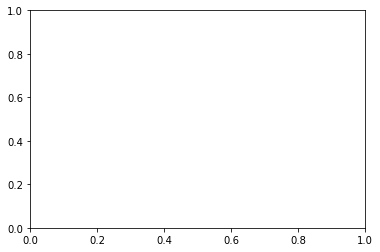

In [72]:
test_cells = [[pheno_data[0][1][2][5], pheno[0]], [pheno_data[1][1][2][1], pheno[1]], [pheno_data[2][1][2][2], pheno[2]]]
colored_scatter(test_cells)